# **Electricity Demand and Price Forecasting Project**


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [3]:
# Import Google Drive to access files stored in Google Drive account
from google.colab import drive

In [4]:
# Mount Google Drive to access the files
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1: Import datasets

In [8]:
# Load weather dataset from Google Drive
weather_df = pd.read_excel('/content/drive/MyDrive/Infosys Project/weather_features.xlsx')

# Load energy dataset from Google Drive
energy_df = pd.read_excel('/content/drive/MyDrive/Infosys Project/energy_dataset.xlsx')

# Step 2: Inspect datasets

In [ ]:
# Display the first few rows of the energy dataset
energy_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17,NaN,6436,26118,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16,NaN,5856,24934,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8,NaN,5454,23515,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2,NaN,5151,22642,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9,NaN,4861,21785,20264.0,38.41,56.04


In [ ]:
# Display the first few rows of the weather dataset
weather_df.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [ ]:
# Display the shape of the energy DataFrame
print("Shape of energy_df:", energy_df.shape)

# Display the shape of the weather DataFrame
print("Shape of weather_df:", weather_df.shape)

Shape of energy_df: (35064, 29)
Shape of weather_df: (178396, 17)


# Step 3: Prepare weather data (EDA: Exploratary Data Analysis)

In [9]:
# Drop the 'city_name' column from the weather dataset as it is no longer needed
weather_df =  weather_df.drop(columns=['city_name'])

# Step 4: Aggregate weather data

In [10]:
# Group the weather data by 'dt_iso' and aggregate using mean for numerical columns
# and mode for categorical columns

# Ensuring categorical columns are treated as strings to avoid sorting issues

weather_df['weather_id'] = weather_df['weather_id'].astype(str)
weather_df['weather_main'] = weather_df['weather_main'].astype(str)
weather_df['weather_description'] = weather_df['weather_description'].astype(str)
weather_df['weather_icon'] = weather_df['weather_icon'].astype(str)

aggregated_df = weather_df.groupby('dt_iso').agg({
    'temp': 'mean',
    'temp_min': 'mean',
    'temp_max': 'mean',
    'pressure': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'wind_deg': 'mean',
    'rain_1h': 'mean',
    'rain_3h': 'mean',
    'snow_3h': 'mean',
    'clouds_all': 'mean',
    'weather_id': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'weather_main': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'weather_description': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'weather_icon': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
}).reset_index()


In [ ]:
# Displaying the first few rows of the aggregated DataFrame
aggregated_df.head()

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n


In [11]:
# Convert 'dt_iso' column to datetime with UTC timezone
aggregated_df['dt_iso'] = pd.to_datetime(aggregated_df['dt_iso'], utc=True)

# Convert 'time' column to datetime with UTC timezone
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)

# Step 5: Merge datasets as a Left Join based on datetime columns

In [12]:
merged_df = pd.merge(energy_df, aggregated_df, left_on='time', right_on='dt_iso')

In [13]:
# Drop the 'dt_iso' column from merged_df
merged_df = merged_df.drop(columns=['dt_iso'])

In [ ]:
# Display the shape (dimensions) of merged_df
merged_df.shape

(35064, 44)

In [ ]:
merged_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,2.0,135.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,2.0,135.8,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,2.4,119.0,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,2.4,119.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,2.4,118.4,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n


In [ ]:
# Display information about the dataframe
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  float64            
 2   generation fossil brown coal/lignite         35064 non-null  float64            
 3   generation fossil coal-derived gas           35064 non-null  float64            
 4   generation fossil gas                        35064 non-null  float64            
 5   generation fossil hard coal                  35064 non-null  float64            
 6   generation fossil oil                        35064 non-null  float64            
 7   generation fossil oil shale                  35064 non-null  float64            
 8   generation fossil peat    

In [ ]:
# Generate and display summary statistics for merged_df
merged_df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all
count,35064.000000,35064.000000,35064.0,35064.000000,35064.000000,35064.000000,35064.0,35064.0,35064.0,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.532797,448.091918,0.0,5622.705653,4256.550622,298.341319,0.0,0.0,0.0,475.563997,...,288.396642,291.147454,1070.205996,68.217013,2.467529,166.614552,0.073212,0.000386,0.004846,24.737415
std,85.346455,354.616732,0.0,2201.557635,1961.973297,52.518371,0.0,0.0,0.0,792.291849,...,7.121843,7.507959,2692.266470,14.890167,1.357751,57.493555,0.202562,0.003360,0.101103,17.306731
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,270.550000,271.941863,812.400000,22.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,0.000000,...,282.950000,285.350000,1012.800000,56.800000,1.400000,126.400000,0.000000,0.000000,0.000000,12.000000
50%,367.000000,509.000000,0.0,4969.500000,4475.000000,300.000000,0.0,0.0,0.0,68.000000,...,287.750000,290.550000,1017.000000,69.800000,2.200000,166.000000,0.000000,0.000000,0.000000,22.400000
75%,433.000000,757.000000,0.0,6429.000000,5839.000000,330.000000,0.0,0.0,0.0,616.000000,...,293.610000,296.750000,1021.000000,80.200000,3.200000,207.800000,0.060000,0.000000,0.000000,35.000000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,4523.000000,...,308.550000,313.548000,202469.000000,100.000000,29.800000,338.000000,4.150000,0.463000,4.300000,93.600000


In [14]:
# Sum numerical columns in merged_df
merged_df.select_dtypes(include=['number']).sum()

generation biomass                             1.344023e+07
generation fossil brown coal/lignite           1.570268e+07
generation fossil coal-derived gas             0.000000e+00
generation fossil gas                          1.970545e+08
generation fossil hard coal                    1.491581e+08
generation fossil oil                          1.045462e+07
generation fossil oil shale                    0.000000e+00
generation fossil peat                         0.000000e+00
generation geothermal                          0.000000e+00
generation hydro pumped storage aggregated     0.000000e+00
generation hydro pumped storage consumption    1.666661e+07
generation hydro run-of-river and poundage     3.406781e+07
generation hydro water reservoir               9.129885e+07
generation marine                              0.000000e+00
generation nuclear                             2.195312e+08
generation other                               2.110771e+06
generation other renewable              

In [15]:
# Drop columns in merged_df that are entirely null or 0-valued
merged_df = merged_df.dropna(axis=1, how='all').loc[:, (merged_df != 0).any(axis=0)]

In [16]:
# Check for missing values in merged_df
merged_df.isnull().sum()

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil coal-derived gas             18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation fossil oil shale                    18
generation fossil peat                         18
generation geothermal                          18
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation marine                              19
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind offshore                       18


In [17]:
# Forward fill missing values in merged_df
merged_df.ffill(inplace=True)

# Backward fill remaining missing values in merged_df
merged_df.bfill(inplace=True)

# Check for any remaining missing values in merged_df
merged_df.isnull().sum()

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil coal-derived gas             0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation fossil oil shale                    0
generation fossil peat                         0
generation geothermal                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation marine                              0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind offshore                       0
generation wind onsh

In [ ]:
# Displaying the first 5 rows of merged_df
merged_df.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,2.0,135.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,2.0,135.8,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,2.4,119.0,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,2.4,119.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,2.4,118.4,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n


In [ ]:
# Displaying the shape (dimensions) of merged_df
merged_df.shape

(35064, 42)

# Step 6: Feature Engginering

Identify and treat the outliers in numerical columns of a DataFrame using Interquartile Range (IQR) Method

In [21]:
# Function to identify outliers in numerical columns of a DataFrame
def identify_outliers_df(df):
    outliers = pd.DataFrame()
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

In [22]:
# Identify outliers in merged_df using identify_outliers_df function
outliers_df = identify_outliers_df(merged_df)

In [23]:
# Counting outliers in each column
outliers_count = outliers_df.sum()
print(outliers_count)

generation biomass                               87
generation fossil brown coal/lignite              0
generation fossil coal-derived gas                0
generation fossil gas                          2185
generation fossil hard coal                       0
generation fossil oil                           246
generation fossil oil shale                       0
generation fossil peat                            0
generation geothermal                             0
generation hydro pumped storage consumption    3762
generation hydro run-of-river and poundage        0
generation hydro water reservoir                343
generation marine                                 0
generation nuclear                               79
generation other                               1267
generation other renewable                        5
generation solar                                  0
generation waste                                328
generation wind offshore                          0
generation w

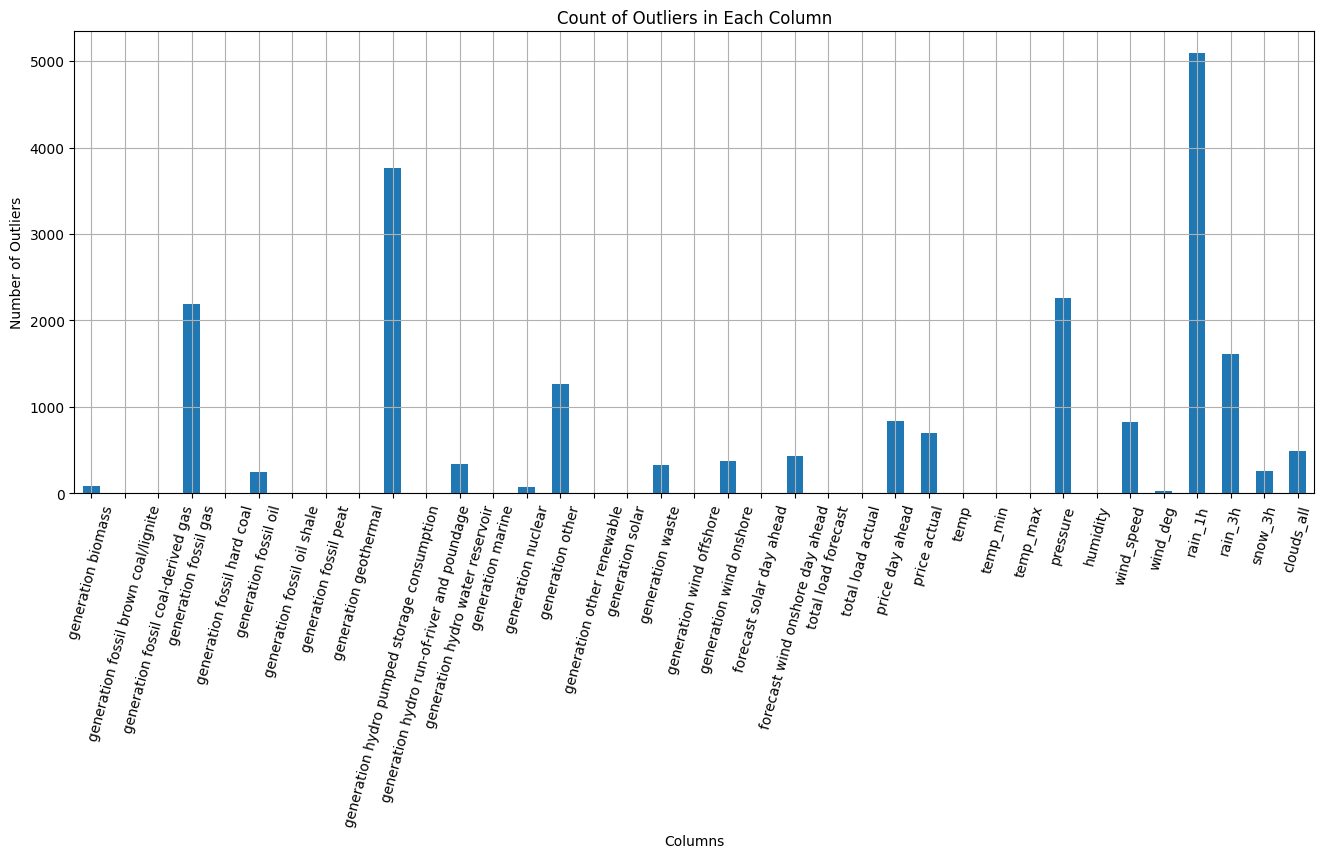

In [29]:
# Counting outliers in each column
outliers_count = outliers_df.sum()

# Plotting outliers count
outliers_count.plot(kind='bar', figsize=(16, 6))
plt.title('Count of Outliers in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=75)
plt.grid(True)
plt.show()


In [40]:
# Function to treat outliers in numerical columns of a DataFrame
def treat_outliers_df(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap outliers to lower and upper bounds
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

In [41]:
treat_outliers_df(merged_df)

In [42]:
outliers_df = identify_outliers_df(merged_df)

In [43]:
outliers_df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,clouds_all,weather_id,weather_main,weather_description,weather_icon,price_actual_interpolated,hour,avg_hourly_demand,peak\off-peak,is_weekend
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35060,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35061,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35062,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Extract new features from the datetime column in merged_df

In [44]:
# Convert 'time' column to datetime with UTC timezone
merged_df['time'] = pd.to_datetime(merged_df['time'], utc=True)

# Extract day of the month
merged_df['day'] = merged_df['time'].dt.day

# Extract month
merged_df['month'] = merged_df['time'].dt.month

 # Extract day of the week (Monday=0, Sunday=6)
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek

In [45]:
# Create binary indicators for each month in merged_df
for month in range(1, 13):
    merged_df[f'month_{month}'] = (merged_df['month'] == month).astype(int)

In [46]:
# Remove the original 'month' column
merged_df.drop(columns=['month'], inplace=True)

In [47]:
# Rename binary indicator columns for each month in merged_df
merged_df.rename(columns={'month_1': 'January', 'month_2': 'February', 'month_3': 'March', 'month_4': 'April', 'month_5': 'May', 'month_6': 'June', 'month_7': 'July',
                           'month_8': 'August', 'month_9': 'September', 'month_10': 'October', 'month_11': 'November', 'month_12': 'December'}, inplace=True)

In [48]:
# Create binary indicators for each day of the week in merged_df
for day in range(7):
    merged_df[f'day_of_week_{day}'] = (merged_df['day_of_week'] == day).astype(int)

In [49]:
# Remove the original 'day_of_week' column
merged_df.drop(columns=['day_of_week'], inplace=True)

In [50]:
# Rename binary indicator columns for each day of week in merged_df
merged_df.rename(columns={'day_of_week_0': 'Monday', 'day_of_week_1': 'Tuesday', 'day_of_week_2': 'Wednesday',
                          'day_of_week_3': 'Thursday', 'day_of_week_4': 'Friday', 'day_of_week_5': 'Saturday',
                          'day_of_week_6': 'Sunday'}, inplace=True)

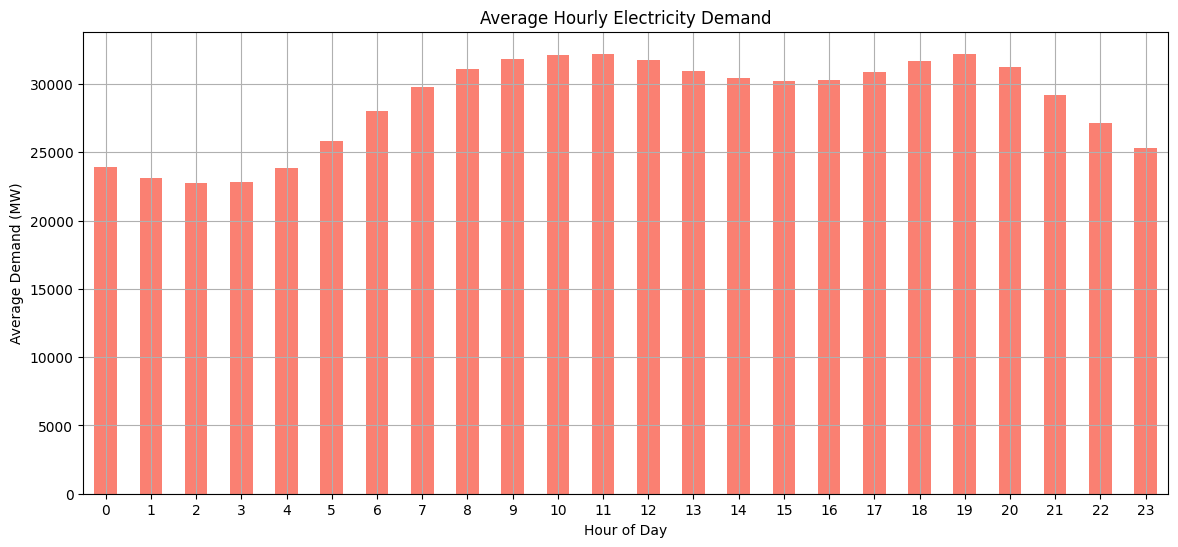

In [51]:
# Extract hour from the datetime column in merged_df
merged_df['hour'] = merged_df['time'].dt.hour

# Calculate average hourly electricity demand
hourly_demand = merged_df.groupby('hour')['total load actual'].mean()

# Plotting average hourly electricity demand
hourly_demand.plot(kind='bar', color='salmon',  figsize=(14, 6))
plt.title('Average Hourly Electricity Demand')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand (MW)')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

**The plotted data indicates peak electricity demand from 7 AM to 10 PM, with lower demand observed during other hours, highlighting distinct daily usage patterns.**

In [52]:
# Create binary indicators for peak and non-peak hours in merged_df
merged_df['peak_hour'] = merged_df['hour'].apply(lambda x: 1 if 7 <= x <= 20 else 0)
merged_df['non_peak_hour'] = merged_df['hour'].apply(lambda x: 1 if x < 7 or x > 20 else 0)

In [ ]:
# Convert 'time' column to string format for exporting
merged_df['time'] = merged_df['time'].astype(str)

output_path = '/content/drive/MyDrive/Infosys Project/merged_dataset.xlsx'

# Export merged_df to Excel file without index column
merged_df.to_excel(output_path, index=False)

In [55]:
merged_df = pd.read_excel('/content/drive/MyDrive/Infosys Project/merged_dataset.xlsx')

In [53]:
merged_df['time'] = pd.to_datetime(merged_df['time'], utc=True)

In [56]:
merged_df.shape

(35064, 64)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 64 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  int64              
 2   generation fossil brown coal/lignite         35064 non-null  int64              
 3   generation fossil gas                        35064 non-null  int64              
 4   generation fossil hard coal                  35064 non-null  int64              
 5   generation fossil oil                        35064 non-null  int64              
 6   generation hydro pumped storage consumption  35064 non-null  int64              
 7   generation hydro run-of-river and poundage   35064 non-null  int64              
 8   generation hydro water res

# Step 7: Visualization

**Time Features and Demand Analysis**

Hourly Demand Analysis

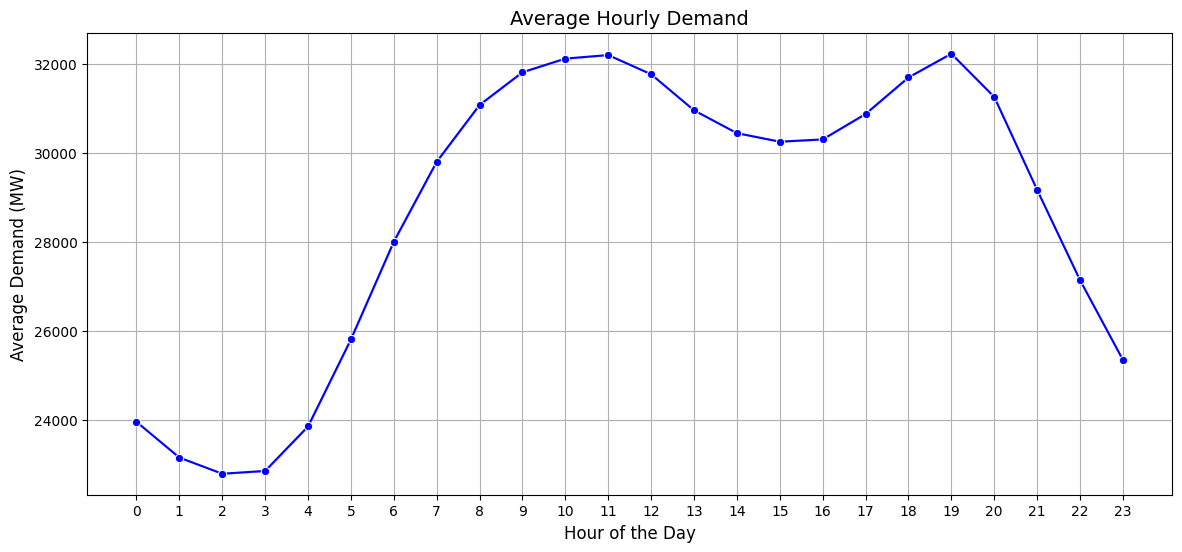

In [64]:
# Plot hourly demand
plt.figure(figsize=(14, 6))
sns.lineplot(data=merged_df, x='hour', y='avg_hourly_demand', estimator='mean', marker='o', color='blue')
plt.title('Average Hourly Demand', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(0, 24, 1), fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# **The average hourly electricity demand peaks around 11 AM and 7 PM, indicating typical times of increased energy usage.**

Average Electricity Demand by Day of the Week

<ipython-input-111-2c8cd2cf30c7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dayofweek_demand.index, y=dayofweek_demand.values, order=day_order, palette='muted')


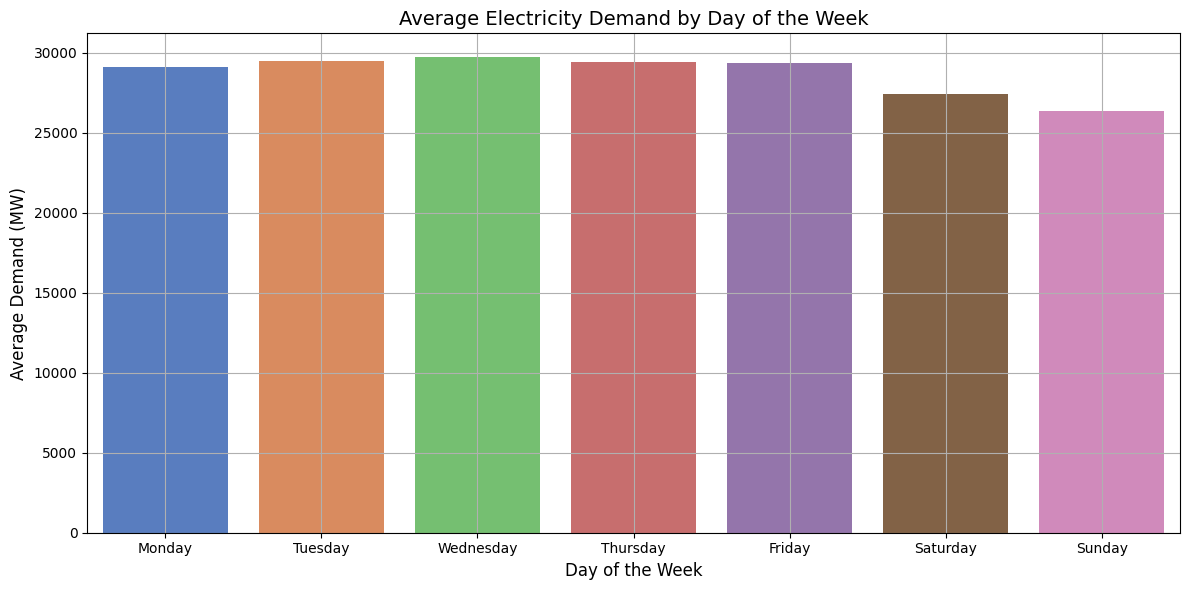

In [ ]:
# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of the week and calculate the mean demand
dayofweek_demand = merged_df.groupby(merged_df['time'].dt.day_name())['total load actual'].mean()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=dayofweek_demand.index, y=dayofweek_demand.values, order=day_order, palette='muted')

# Adding labels and title
plt.title('Average Electricity Demand by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()



# **The line graph shows higher electricity demand on weekdays compared to Sundays. This is likely because businesses and factories are closed on Sundays.**

Weekend vs. Weekday Demand Comparison

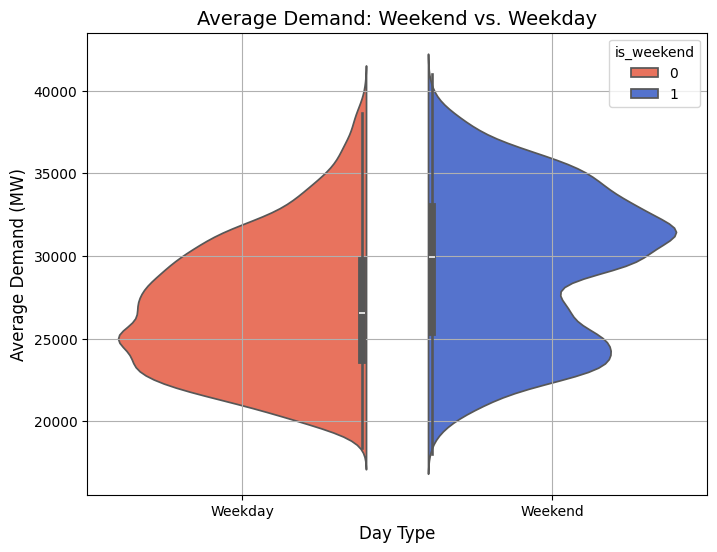

In [ ]:
# Plot weekend vs. weekday demand
plt.figure(figsize=(8, 6))
sns.violinplot(data=merged_df, x='is_weekend', y=demand_column, hue='is_weekend', palette=['#FF6347', '#4169E1'], split=True)
plt.title('Average Demand: Weekend vs. Weekday', fontsize=14)
plt.xlabel('Day Type', fontsize=12)
plt.ylabel('Average Demand (MW)', fontsize=12)
plt.xticks([0, 1], ['Weekday', 'Weekend'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

# **Weekdays have higher electricity demand than weekends due to business operations.**

# Temporal Trends and Seasonality

Electricity Demand Over Time

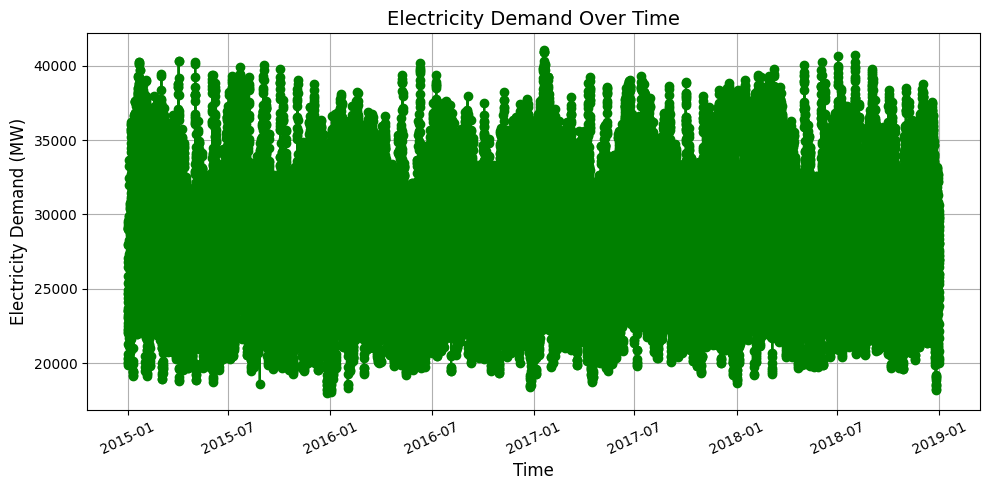

In [ ]:
# Plot of Electricity Demand Over Time
plt.figure(figsize=(10, 5))
plt.plot(merged_df['time'], merged_df[demand_column], marker='o', linestyle='-', color='green')
plt.title('Electricity Demand Over Time', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Electricity Demand (MW)', fontsize=12)
plt.xticks(rotation=25, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


# **The graph shows gradual increase in electricity demand over four and a half years.**

Counts of Weekdays and Weekends

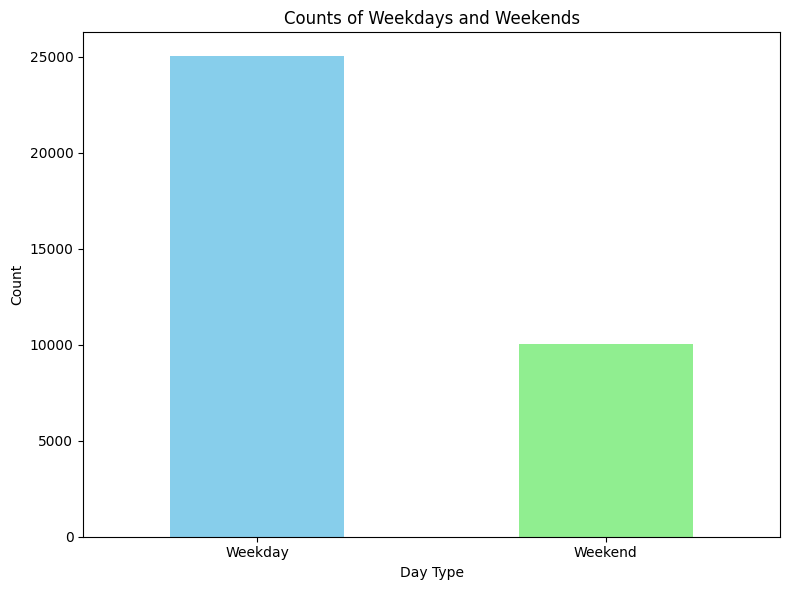

In [ ]:
day_type_counts = merged_df['is_weekend'].value_counts()

plt.figure(figsize=(8, 6))
day_type_counts.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Counts of Weekdays and Weekends')
plt.xlabel('Day Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
plt.tight_layout()
plt.show()

# **The count for weekdays is higher based on the overall increasing trend observed in the graph.**

# Weather and Demand Analysis

Temperature Distribution

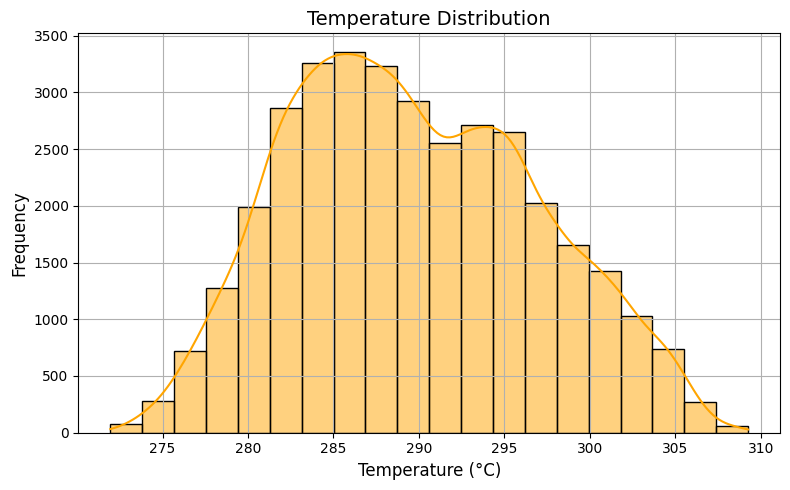

In [ ]:
# Histogram of Temperature Distribution
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['temp'], bins=20, kde=True, color='orange')
plt.title('Temperature Distribution', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# **The Histogram shows a gradual increase in temperature in degrees Celsius.**

Average Electricity Demand by Weather Condition

<ipython-input-79-a52434041695>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weather_description', y=demand_column, data=merged_df, estimator=np.mean, palette='Set2')


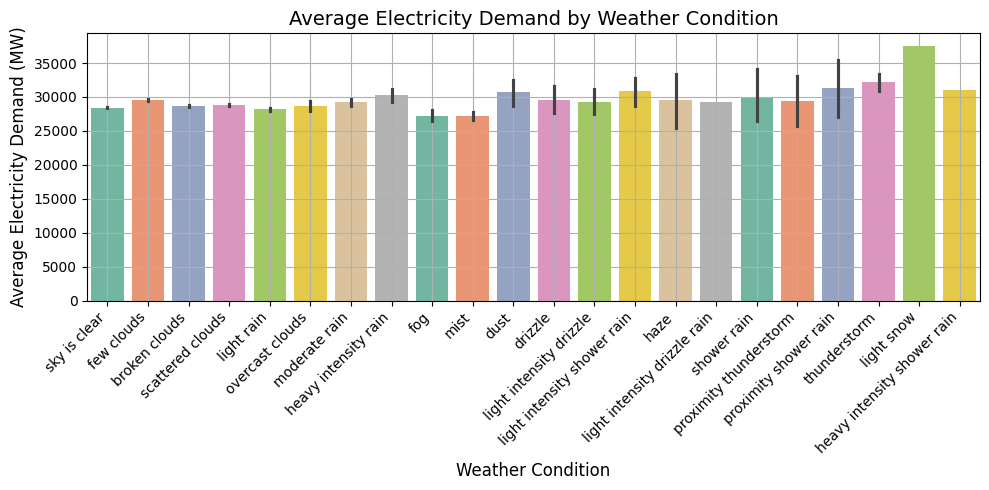

In [ ]:
# Bar Plot of Average Electricity Demand by Weather Condition
plt.figure(figsize=(10, 5))
sns.barplot(x='weather_description', y=demand_column, data=merged_df, estimator=np.mean, palette='Set2')
plt.title('Average Electricity Demand by Weather Condition', fontsize=14)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Average Electricity Demand (MW)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Examining average electricity demand by weather, this graph suggests a correlation between extreme temperatures (hot or cold) and higher electricity usage.**

# Peak vs. Non-Peak Hours

Average Electricity Demand During Peak vs. Non-Peak Hours

<ipython-input-114-1afd64042916>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=peak_demand, x='peak_hour', y='total load actual', palette=['blue', 'red'])


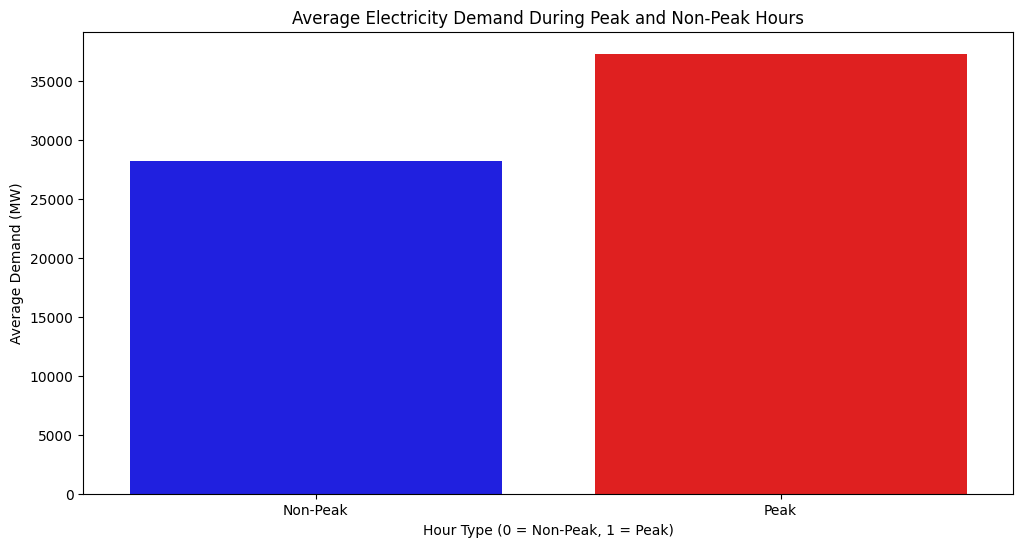

In [ ]:
merged_df['peak_hour'] = merged_df['total load actual'] > merged_df['total load actual'].quantile(0.95)

try:
    peak_demand = merged_df.groupby('peak_hour')['total load actual'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=peak_demand, x='peak_hour', y='total load actual', palette=['blue', 'red'])
    plt.title('Average Electricity Demand During Peak and Non-Peak Hours')
    plt.xlabel('Hour Type (0 = Non-Peak, 1 = Peak)')
    plt.ylabel('Average Demand (MW)')
    plt.xticks(ticks=[0, 1], labels=['Non-Peak', 'Peak'])
    plt.show()

except KeyError as e:
    print(f"KeyError: {str(e)}. Make sure 'peak_hour' column exists and is correctly spelled.")

# **Based on the graph, average electricity demand is higher during peak hours than non-peak hours.**

# Additional Insights

Histogram of Total Load Actual and Price Actual

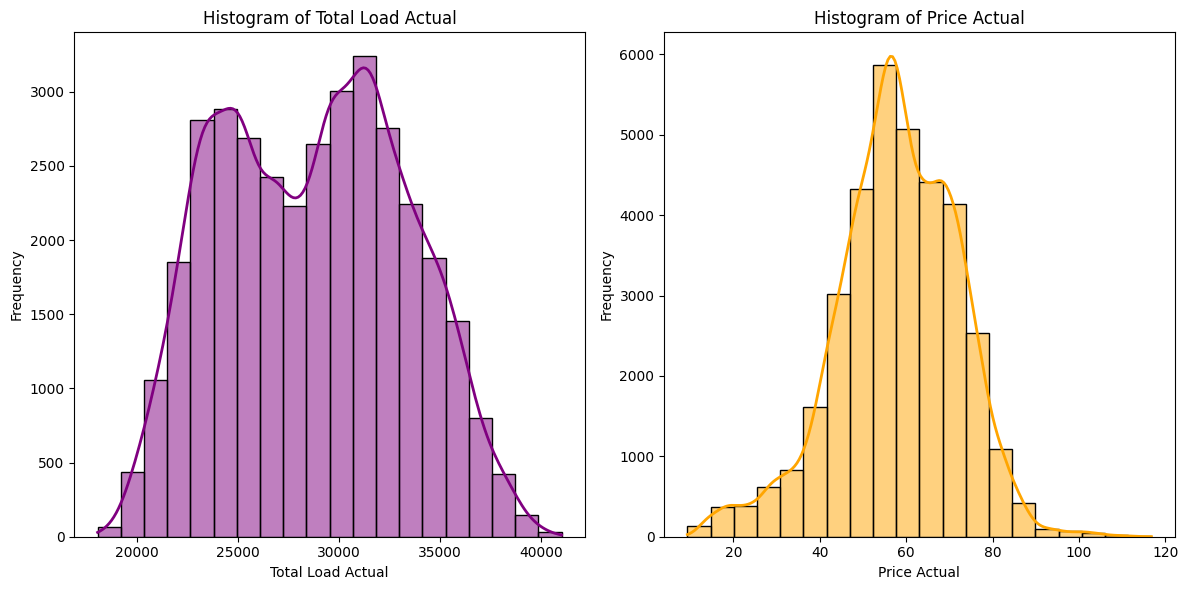

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram for 'total load actual'
plt.subplot(1, 2, 1)
sns.histplot(merged_df['total load actual'], bins=20, kde=True, color='purple', line_kws={'linewidth': 2})
plt.title('Histogram of Total Load Actual')
plt.xlabel('Total Load Actual')
plt.ylabel('Frequency')

# Histogram for 'price actual'
plt.subplot(1, 2, 2)
sns.histplot(merged_df['price actual'], bins=20, kde=True, color='orange', line_kws={'linewidth': 2})
plt.title('Histogram of Price Actual')
plt.xlabel('Price Actual')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# **Analyzing the histograms, Total Load Actual appears more frequent at higher values compared to Price Actual.**

Average Electricity Demand by Weather Condition

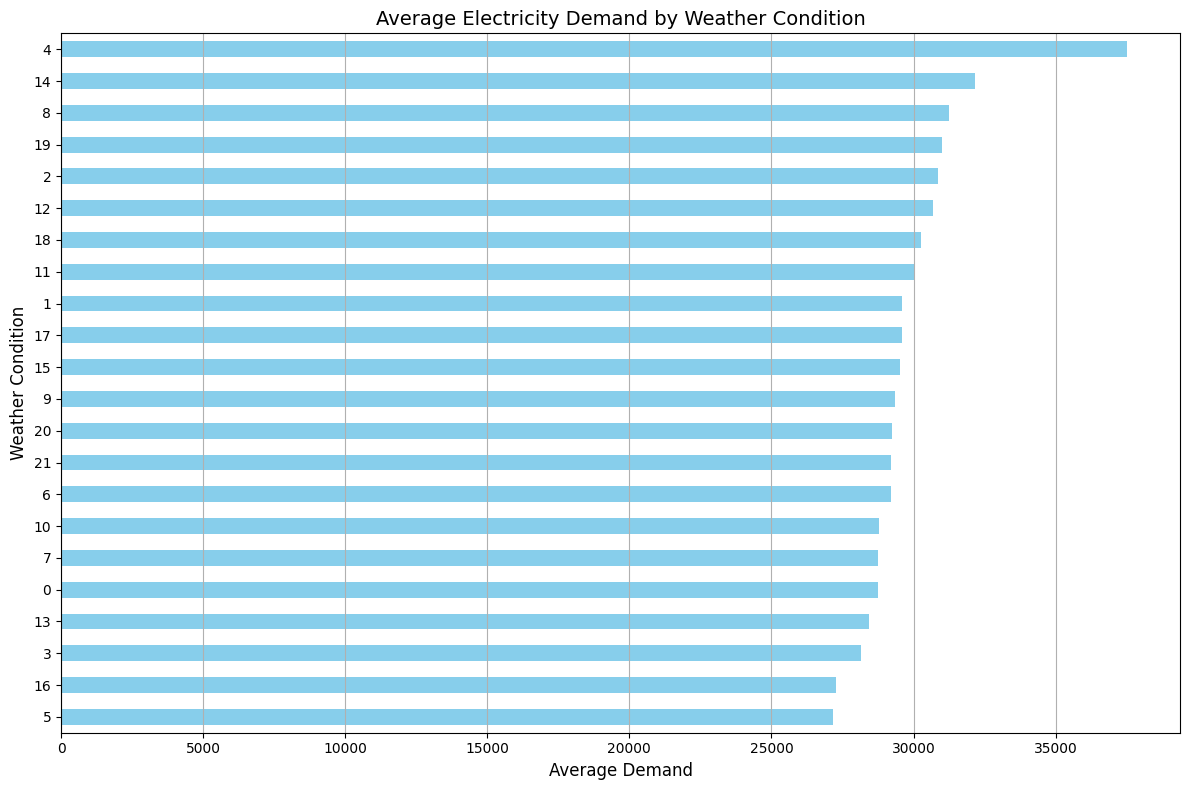

In [ ]:
plt.figure(figsize=(12, 8))

# Sort weather conditions by average demand
avg_demand_by_weather = merged_df.groupby('weather_description')['total load actual'].mean().sort_values()

# Horizontal bar plot
avg_demand_by_weather.plot(kind='barh', color='skyblue')

plt.title('Average Electricity Demand by Weather Condition', fontsize=14)
plt.xlabel('Average Demand', fontsize=12)
plt.ylabel('Weather Condition', fontsize=12)
plt.yticks(fontsize=10)
plt.grid(True, axis='x')

plt.tight_layout()
plt.show()


# **Shows higher electricity use during extreme weather (hot or cold) compared to moderate temperatures.**

Electricity Demand vs Temperature Scatter Plot

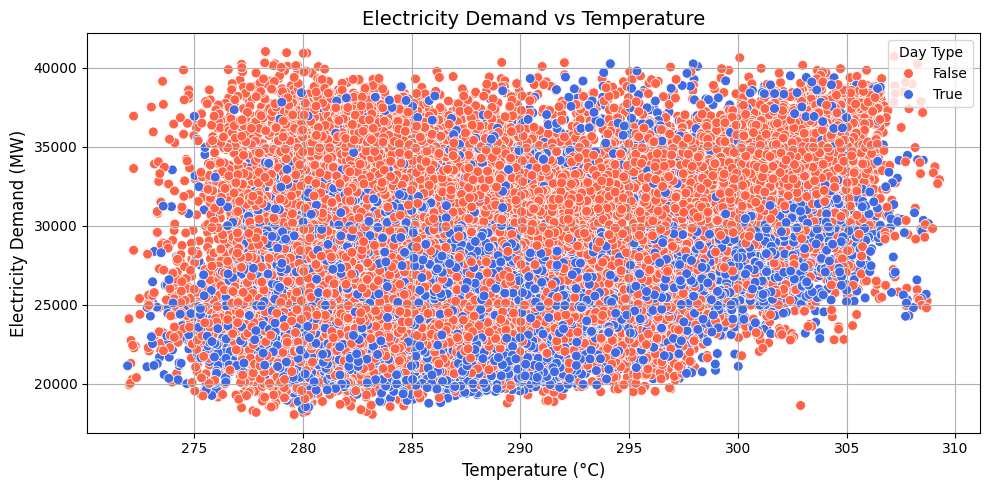

In [ ]:
# Scatter Plot: Electricity Demand vs Temperature
plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged_df, x='temp', y=demand_column, hue='is_weekend', palette=['#FF6347', '#4169E1'], s=50)
plt.title('Electricity Demand vs Temperature', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Electricity Demand (MW)', fontsize=12)
plt.grid(True)
plt.legend(title='Day Type', loc='upper right')
plt.tight_layout()
plt.show()

# **There appears to be a positive correlation between temperature and electricity demand, meaning electricity demand increases as temperature rises.**

Temperature and Demand Correlation Heatmap

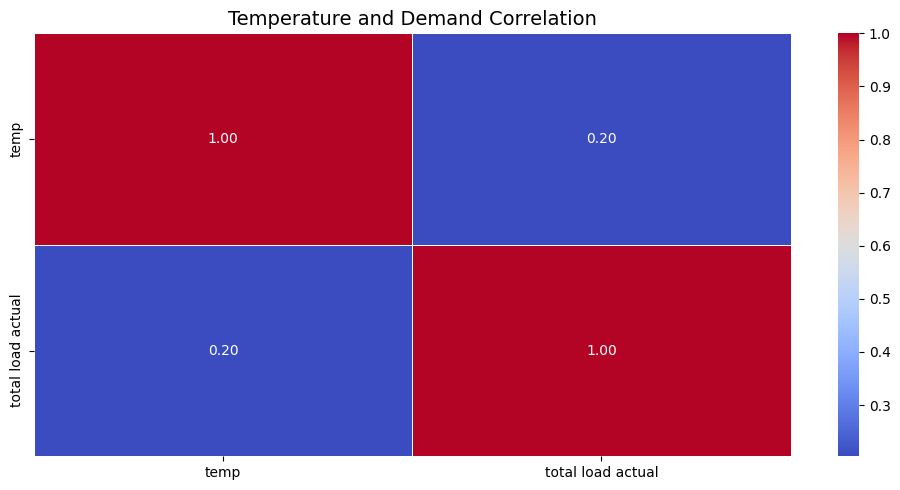

In [ ]:
# Heatmap: Correlation between Temperature and Demand
plt.figure(figsize=(10, 5))
corr = merged_df[['temp', demand_column]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Temperature and Demand Correlation', fontsize=14)
plt.tight_layout()
plt.show()

# **This heatmap shows higher electricity demand during hot weather (red) and potentially less during cold weather (blue).**

# Step 8: Correlation Matrix

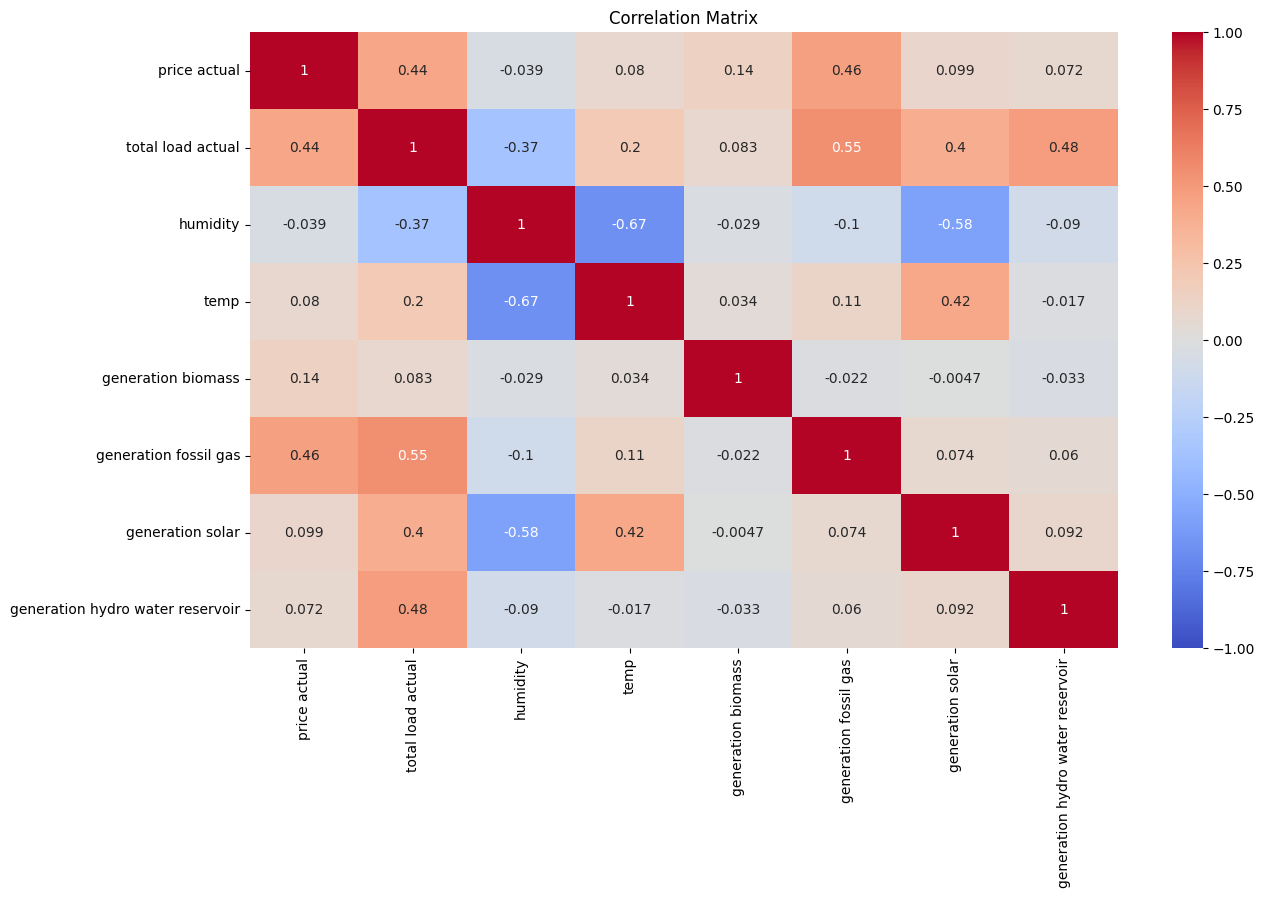

In [ ]:
# Define relevant columns for correlation matrix
columns_of_interest = ['price actual', 'total load actual', 'humidity', 'temp',
                       'generation biomass', 'generation fossil gas',
                       'generation solar', 'generation hydro water reservoir']

# Subset the dataset to include only the columns of interest
subset_data = merged_df[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = subset_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


### **Price and Demand Fluctuations:** This plot explores how electricity demand (total load actual) and price (price actual) fluctuate throughout the day and potentially across seasons. The inclusion of variables like temperature and humidity could indicate an investigation into how weather patterns influence these fluctuations. This also defines the correlation between them.

# Step 9: Labeled Regression Line Plot

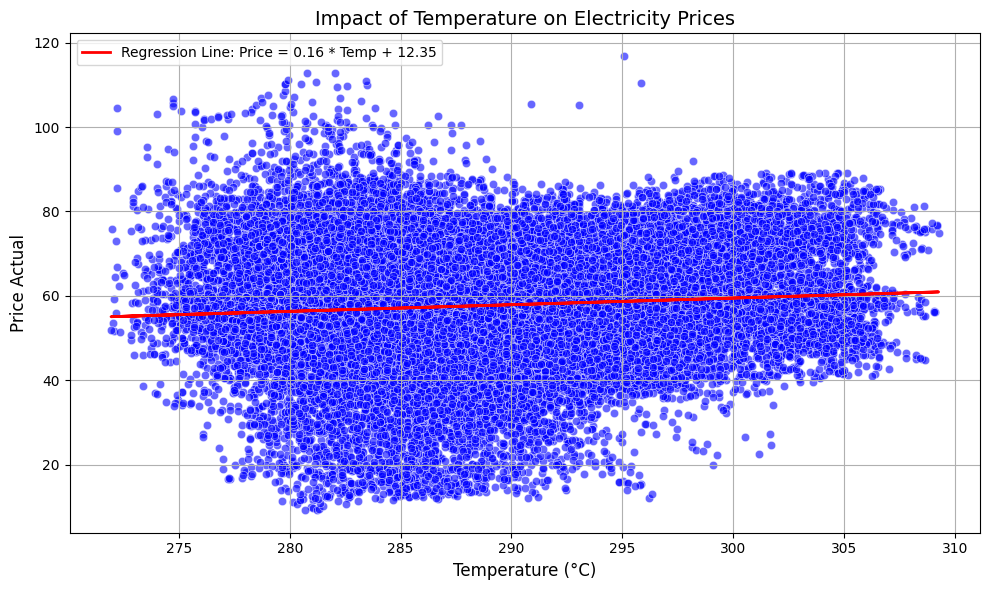

In [69]:
merged_df['time'] = pd.to_datetime(merged_df['time'], errors='coerce')

# Perform linear regression
X = merged_df[['temp']]  # Temperature as input feature
y = merged_df['price actual']  # Price actual as target variable
reg = LinearRegression().fit(X, y)

y_pred = reg.predict(X)

plt.figure(figsize=(10, 6))

# Scatter plot of price vs temp
sns.scatterplot(x='temp', y='price actual', data=merged_df, color='b', alpha=0.6)

# Regression line with label
plt.plot(X, y_pred, color='red', linewidth=2, label=f'Regression Line: Price = {reg.coef_[0]:.2f} * Temp + {reg.intercept_:.2f}')

plt.title('Impact of Temperature on Electricity Prices', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Price Actual', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# **This scatter plot shows a positive correlation between temperature and electricity prices. Warmer weather likely means higher electricity demand for cooling, pushing prices up.**

In [70]:
# Initialize a dictionary to store label encoders for each categorical column
label_encoder = {}

# Iterate through each column in the dataframe that has object dtype (categorical columns)
for column in merged_df.select_dtypes(include=['object']).columns:
    # Create a LabelEncoder instance for the column
    label_encoder[column] = LabelEncoder()

    # Check if the column contains mixed types and convert to string if necessary
    if merged_df[column].apply(type).nunique() > 1:
        merged_df[column] = merged_df[column].astype(str)

    # Apply label encoding to the column
    merged_df[column] = label_encoder[column].fit_transform(merged_df[column])

# Now merged_df contains encoded values for categorical columns

In [71]:
merged_df.drop(columns=['time'],inplace=True)

# Step 10: Recursive Feature Elimination (RFE) Method

In [103]:
# Define the feature columns for load and price forecasting
features_demand = merged_df[['generation biomass', 'generation fossil brown coal/lignite','generation fossil gas', 'generation fossil hard coal',
                   'generation hydro run-of-river and poundage', 'generation hydro water reservoir','generation other renewable',
                   'generation fossil oil', 'generation hydro pumped storage consumption','generation nuclear', 'generation other',
                   'generation solar', 'generation waste', 'generation wind onshore','forecast solar day ahead',
                   'forecast wind onshore day ahead','total load forecast', 'price day ahead', 'temp', 'temp_min',
                   'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg','rain_1h', 'snow_3h', 'clouds_all',
                   'Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
                   'Dec', 'Mon', 'Tus', 'Wed', 'Thur', 'Fri',
                   'Sat', 'Sun', 'hour', 'peak\\off-peak']]

features_price = merged_df[['generation biomass', 'generation fossil brown coal/lignite','generation fossil gas', 'generation fossil hard coal',
                   'generation hydro run-of-river and poundage', 'generation hydro water reservoir','generation other renewable',
                   'generation fossil oil', 'generation hydro pumped storage consumption','generation nuclear', 'generation other',
                   'generation solar', 'generation waste', 'generation wind onshore','forecast solar day ahead',
                   'forecast wind onshore day ahead','total load forecast', 'temp', 'temp_min',
                   'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg','rain_1h', 'snow_3h', 'clouds_all',
                   'Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
                   'Dec', 'Mon', 'Tus', 'Wed', 'Thur', 'Fri',
                   'Sat', 'Sun', 'hour', 'peak\\off-peak']]

target_demand = merged_df['total load actual']
target_price = merged_df['price actual']

# Split the dataset into training and testing sets for load forecasting
X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(features_demand, target_demand, test_size=0.3, random_state=40)
# Split the dataset into training and testing sets for price forecasting
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features_price, target_price, test_size=0.3, random_state=40)

Feature Selection For Load Prediction

In [ ]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Feature selection using RFE for load prediction with a specific number of features
n_features_to_select = 40
rfe_demand = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_demand.fit(X_train_demand, y_train_demand)

selected_features_demand = X_train_demand.columns[rfe_demand.support_]
print("Selected features for load prediction:", selected_features_demand)

Selected features for load prediction: Index(['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation other renewable',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation other', 'generation solar', 'forecast solar day ahead',
       'total load forecast', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Mon', 'Tus', 'Wed', 'Thur', 'Fri', 'Sat',
       'Sun', 'hour', 'peak\off-peak'],
      dtype='object')


Feature Selection For Price Prediction

In [ ]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Feature selection using RFE for price prediction with a specific number of features
n_features_to_select = 40
rfe_price = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_price.fit(X_train_price, y_train_price)

selected_features_price = X_train_price.columns[rfe_price.support_]
print("Selected features for price prediction:", selected_features_price)

Selected features for price prediction: Index(['generation biomass', 'generation fossil gas',
       'generation fossil hard coal',
       'generation hydro run-of-river and poundage',
       'generation other renewable', 'generation fossil oil',
       'generation hydro pumped storage consumption', 'generation other',
       'generation waste', 'forecast solar day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Mon', 'Tus', 'Wed', 'Thur', 'Fri', 'Sat',
       'Sun', 'hour', 'peak\off-peak'],
      dtype='object')


In [ ]:
# Define the feature columns for load forecasting
features_demand = merged_df[['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation other renewable',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation other', 'generation solar', 'forecast solar day ahead',
       'total load forecast', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Mon', 'Tus', 'Wed', 'Thur', 'Fri', 'Sat',
       'Sun', 'hour', 'peak\off-peak']]

# Define the feature columns for price forecasting
features_price = merged_df[['generation biomass', 'generation fossil gas',
       'generation fossil hard coal',
       'generation hydro run-of-river and poundage',
       'generation other renewable', 'generation fossil oil',
       'generation hydro pumped storage consumption', 'generation other',
       'generation waste', 'forecast solar day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Mon', 'Tus', 'Wed', 'Thur', 'Fri', 'Sat',
       'Sun', 'hour', 'peak\off-peak']]

# Define the target variable for load forecasting
target_demand = merged_df['total load actual']

# Define the target variable for price forecasting
target_price = merged_df['price actual']

# Split the dataset into training and testing sets for load forecasting
X_train_demand, X_test_demand, y_train_demand, y_test_demand = train_test_split(features_demand, target_demand, test_size=0.3, random_state=40)

# Split the dataset into training and testing sets for price forecasting
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features_price, target_price, test_size=0.3, random_state=40)

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Feature selection using RFE for load prediction with a specific number of features
n_features_to_select = 40
rfe_demand = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_demand.fit(X_train_demand, y_train_demand)

# Get selected features for load prediction
selected_features_demand = X_train_demand.columns[rfe_demand.support_]
print("Selected features for load prediction:", selected_features_demand)

# Feature selection using RFE for price prediction with a specific number of features
rfe_price = RFE(estimator=lr_model, n_features_to_select=n_features_to_select)
rfe_price.fit(X_train_price, y_train_price)

# Get selected features for price prediction
selected_features_price = X_train_price.columns[rfe_price.support_]
print("\nSelected features for price prediction:", selected_features_price)

Selected features for load prediction: Index(['generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation other renewable',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation other', 'generation solar', 'forecast solar day ahead',
       'total load forecast', 'price day ahead', 'temp', 'temp_min',
       'temp_max', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec', 'Mon', 'Tus', 'Wed', 'Thur', 'Fri', 'Sat',
       'Sun', 'hour', 'peak\off-peak'],
      dtype='object')

Selected features for price prediction: Index(['generation biomass', 'generation fossil gas',
       'generation fossil hard coal',
       'generation hydro run-of-river and poundage',
       'generation other renewable', 'generation fossil oil',
       'generation hydro pumped storage consumption', 'generation ot

# Step 11: Linear Regression Model

For Load Prediction

In [ ]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training set
lr_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_demand)

# Calculate Mean Absolute Percentage Error (MAPE)
mape_lr = mean_absolute_percentage_error(y_test_demand, y_pred_lr)
print(f'Linear Regression for Load \n  MAPE : {mape_lr * 100:.2f}%')

# Calculate Mean Absolute Error (MAE)
mae_lr = mean_absolute_error(y_test_demand, y_pred_lr)
print(f'  MAE : {mae_lr:.2f}')

# Calculate Root Mean Squared Error (RMSE)
rmse_lr = np.sqrt(mean_squared_error(y_test_demand, y_pred_lr))
print(f'  RMSE : {rmse_lr:.2f}')

# Calculate R-squared (R^2)
r2_lr = r2_score(y_test_demand, y_pred_lr)
print(f'  R2 : {r2_lr:.2f}')

# Function to calculate Adjusted R-squared
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Calculate Adjusted R-squared
adjusted_r2_lr = adjusted_r2_score(r2_lr, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_lr:.2f}')


Linear Regression for Load 
  MAPE : 1.10%
  MAE : 314.41
  RMSE : 474.47
  R2 : 0.99
  Adjusted R2 : 0.99


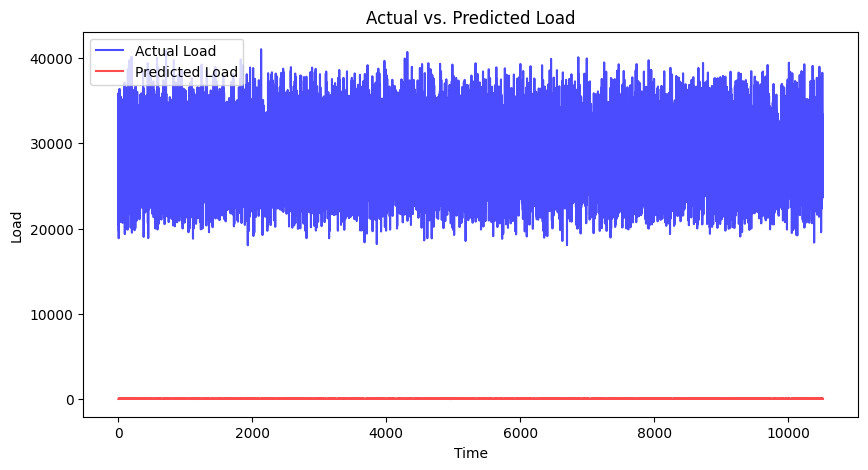

In [ ]:
# Plotting Actual vs. Predicted Load
plt.figure(figsize=(10, 5))
plt.plot(y_test_demand.values, label='Actual Load', color='blue', alpha=0.7)
plt.plot(y_pred_lr, label='Predicted Load', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

For Price Prediction

In [ ]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training set for price prediction
lr_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_price)

# Calculate Mean Absolute Percentage Error (MAPE)
mape_lr = mean_absolute_percentage_error(y_test_price, y_pred_lr)
print(f'Linear Regression for Price \n  MAPE : {mape_lr * 100:.2f}%')

# Calculate Mean Absolute Error (MAE)
mae_lr = mean_absolute_error(y_test_price, y_pred_lr)
print(f'  MAE : {mae_lr:.2f}')

# Calculate Root Mean Squared Error (RMSE)
rmse_lr = np.sqrt(mean_squared_error(y_test_price, y_pred_lr))
print(f'  RMSE : {rmse_lr:.2f}')

# Calculate R-squared (R^2)
r2_lr = r2_score(y_test_price, y_pred_lr)
print(f'  R2 : {r2_lr:.2f}')

# Calculate Adjusted R-squared
adjusted_r2_lr = adjusted_r2_score(r2_lr, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_lr:.2f}')

Linear Regression for Price 
  MAPE : 15.76%
  MAE : 7.73
  RMSE : 9.86
  R2 : 0.53
  Adjusted R2 : 0.53


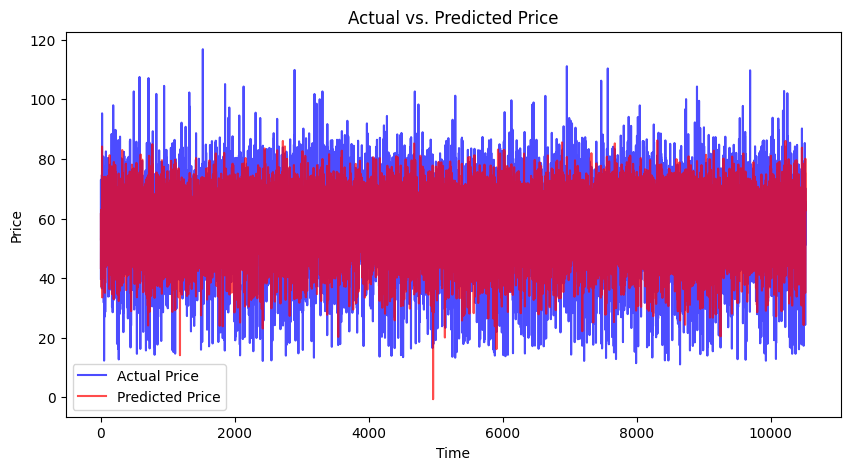

In [ ]:
# Plotting Actual vs. Predicted Price
plt.figure(figsize=(10, 5))
plt.plot(y_test_price.values, label='Actual Price', color='blue', alpha=0.7)
plt.plot(y_pred_lr, label='Predicted Price', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 11: Decision Tree Model

For Load Prediction

In [ ]:
# Initialize the Decision Tree Regressor model with a random state for reproducibility
dt_model = DecisionTreeRegressor(random_state=40)

# Train the model on the training set
dt_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test_demand)

# Calculate the errors
mape_dt = mean_absolute_percentage_error(y_test_demand, y_pred_dt)
print(f'Decision Tree for Load \n  MAPE : {mape_dt * 100:.2f}%')

mae_dt = mean_absolute_error(y_test_demand, y_pred_dt)
print(f'  MAE : {mae_dt:.2f}')

rmse_dt = np.sqrt(mean_squared_error(y_test_demand, y_pred_dt))
print(f'  RMSE : {rmse_dt:.2f}')

r2_dt = r2_score(y_test_demand, y_pred_dt)
print(f'  R2 : {r2_dt:.2f}')

adjusted_r2_dt = adjusted_r2_score(r2_dt, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_dt:.2f}')

Decision Tree for Load 
  MAPE : 1.45%
  MAE : 417.40
  RMSE : 606.89
  R2 : 0.98
  Adjusted R2 : 0.98


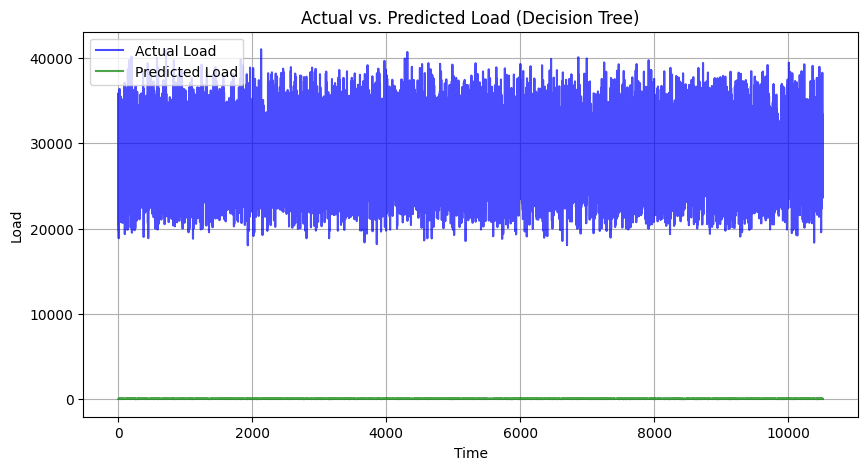

In [ ]:
# Plotting Actual vs. Predicted Load
plt.figure(figsize=(10, 5))
plt.plot(y_test_demand.values, label='Actual Load', color='blue', alpha=0.7)
plt.plot(y_pred_dt, label='Predicted Load', color='green', alpha=0.7)
plt.title('Actual vs. Predicted Load (Decision Tree)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()

For Price Prediction

In [ ]:
# Initialize the Decision Tree Regressor model with a random state for reproducibility
dt_model = DecisionTreeRegressor(random_state=40)

# Train the model on the training set
dt_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test_price)

# Calculate the errors
mape_dt = mean_absolute_percentage_error(y_test_price, y_pred_dt)
print(f'Decision Tree for Price \n  MAPE : {mape_dt * 100:.2f}%')

mae_dt = mean_absolute_error(y_test_price, y_pred_dt)
print(f'  MAE : {mae_dt:.2f}')

rmse_dt = np.sqrt(mean_squared_error(y_test_price, y_pred_dt))
print(f'  RMSE : {rmse_dt:.2f}')

r2_dt = r2_score(y_test_price, y_pred_dt)
print(f'  R2 : {r2_dt:.2f}')

adjusted_r2_dt = adjusted_r2_score(r2_dt, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_dt:.2f}')

Decision Tree for Price
  MAPE : 9.26%
  MAE : 4.68
  RMSE : 7.42
  R2 : 0.73
  Adjusted R2 : 0.73


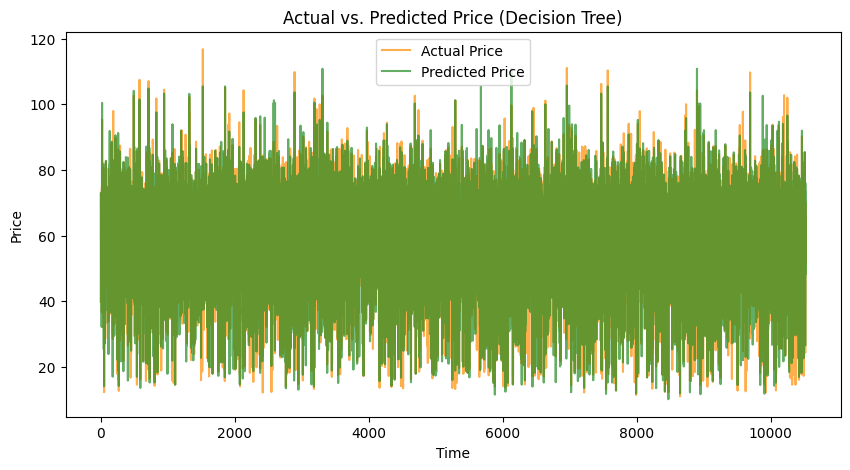

In [ ]:
# Plotting Actual vs. Predicted Price
plt.figure(figsize=(10, 5))
plt.plot(y_test_price.values, label='Actual Price', color='darkorange', alpha=0.7)
plt.plot(y_pred_dt, label='Predicted Price', color='forestgreen', alpha=0.7)
plt.title('Actual vs. Predicted Price (Decision Tree)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 12: Random Forest Model (without parameter tuning)

For Load Prediction

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=40)

# Fit the model on the training data
rf_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_demand)

# Calculate metrics
mape_rf = mean_absolute_percentage_error(y_test_demand, y_pred_rf)
mae_rf = mean_absolute_error(y_test_demand, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_demand, y_pred_rf))
r2_rf = r2_score(y_test_demand, y_pred_rf)

adjusted_r2_rf = adjusted_r2_score(r2_rf, X_test_demand.shape[0], X_test_demand.shape[1])

# Print metrics
print(f'Random Forest for Load \n  MAPE : {mape_rf * 100:.2f}%')
print(f'  MAE : {mae_rf:.2f}')
print(f'  RMSE : {rmse_rf:.2f}')
print(f'  R2 : {r2_rf:.2f}')
print(f'  Adjusted R2 : {adjusted_r2_rf:.2f}')

Random Forest for Load 
  MAPE : 1.03%
  MAE : 295.21
  RMSE : 450.86
  R2 : 0.99
  Adjusted R2 : 0.99


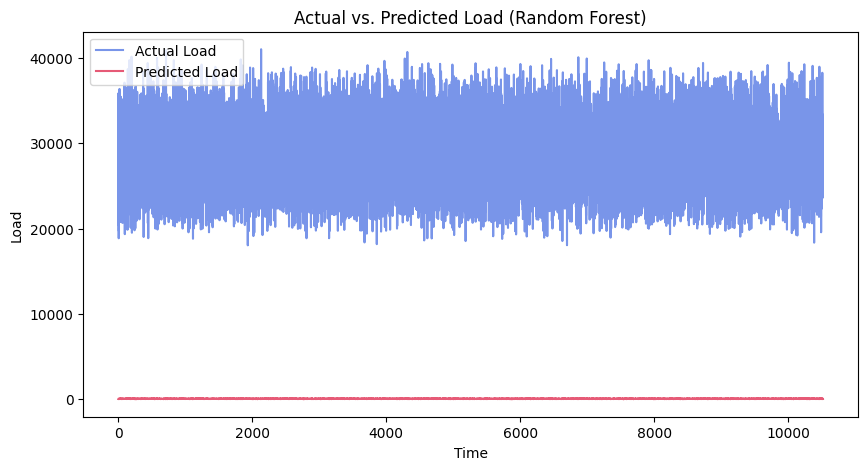

In [ ]:
# Plotting Actual vs. Predicted Load
plt.figure(figsize=(10, 5))
plt.plot(y_test_demand.values, label='Actual Load', color='royalblue', alpha=0.7)
plt.plot(y_pred_rf, label='Predicted Load', color='crimson', alpha=0.7)
plt.title('Actual vs. Predicted Load (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

For Price Prediction

In [ ]:
# Initialize the Random Forest Regressor model with a random state for reproducibility
rf_model = RandomForestRegressor(random_state=40)

# Fit the model on the training data for price prediction
rf_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_price)

# Calculate the errors
mape_rf = mean_absolute_percentage_error(y_test_price, y_pred_rf)
print(f'Random Forest for Price \n  MAPE : {mape_rf * 100:.2f}%')

mae_rf = mean_absolute_error(y_test_price, y_pred_rf)
print(f'  MAE : {mae_rf:.2f}')

rmse_rf = np.sqrt(mean_squared_error(y_test_price, y_pred_rf))
print(f'  RMSE : {rmse_rf:.2f}')

r2_rf = r2_score(y_test_price, y_pred_rf)
print(f'  R2 : {r2_rf:.2f}')

adjusted_r2_rf = adjusted_r2_score(r2_rf, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_rf:.2f}')

Random Forest for Price 
  MAPE : 6.92%
  MAE : 3.41
  RMSE : 4.90
  R2 : 0.88
  Adjusted R2 : 0.88


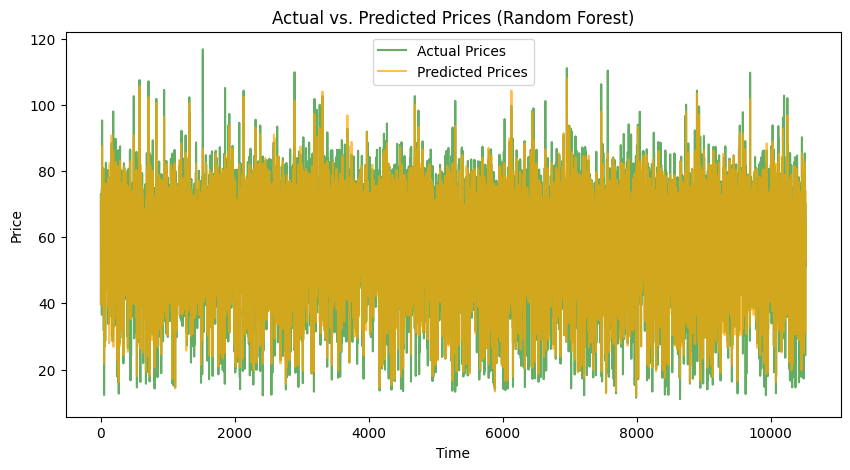

In [ ]:
# Plotting Actual vs. Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_price.values, label='Actual Prices', color='forestgreen', alpha=0.7)
plt.plot(y_pred_rf, label='Predicted Prices', color='orange', alpha=0.7)
plt.title('Actual vs. Predicted Prices (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 13: Random Forest Model (with parameter tuning)

For Load Prediction

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the simplified parameter grid for Random Forest
param_distributions = {
    'n_estimators': randint(50, 101),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3),
    'max_features': ['sqrt']
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=40)

# Initialize RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                   n_iter=20, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error',
                                   random_state=40, verbose=2)

# Reduce the training data size for faster hyperparameter tuning
X_train_sample = X_train_demand.sample(frac=0.3, random_state=40)
y_train_sample = y_train_demand.sample(frac=0.3, random_state=40)

# Fit the model to find the best parameters
random_search.fit(X_train_sample, y_train_sample)

# Get the best parameters
best_params_demand = random_search.best_params_

# Train the Random Forest model with the best parameters
rf_model_tuned = RandomForestRegressor(**best_params_demand, random_state=40)
rf_model_tuned.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_rf_tuned = rf_model_tuned.predict(X_test_demand)

# Calculate metrics
mape_rf_tuned = mean_absolute_percentage_error(y_test_demand, y_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_test_demand, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test_demand, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test_demand, y_pred_rf_tuned)

# Calculate adjusted R²
def adjusted_r2_score(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

adjusted_r2_rf_tuned = adjusted_r2_score(r2_rf_tuned, X_test_demand.shape[0], X_test_demand.shape[1])

# Print best parameters and metrics
print(f'\nRandom Forest (Tuned) for Load \n  MAPE : {mape_rf_tuned * 100:.2f}%')
print(f'  MAE : {mae_rf_tuned:.2f}')
print(f'  RMSE : {rmse_rf_tuned:.2f}')
print(f'  R2 : {r2_rf_tuned:.2f}')
print(f'  Adjusted R2 : {adjusted_r2_rf_tuned:.2f}')

# Print best parameters and score
best_estimator = random_search.best_estimator_
best_score = -random_search.best_score_
best_params = random_search.best_params_

print(f"\nAcross all searched parameters")
print(f"  The best estimator: {best_estimator}")
print(f"  The best score: {best_score:.4f}")
print(f"  The best parameters: {best_params}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Random Forest (Tuned) for Load 
  MAPE : 1.28%
  MAE : 364.06
  RMSE : 514.97
  R2 : 0.99
  Adjusted R2 : 0.99

Across all searched parameters
  The best estimator: RandomForestRegressor(max_features='sqrt', min_samples_split=3, n_estimators=66,
                      random_state=40)
  The best score: 0.0177
  The best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 66}


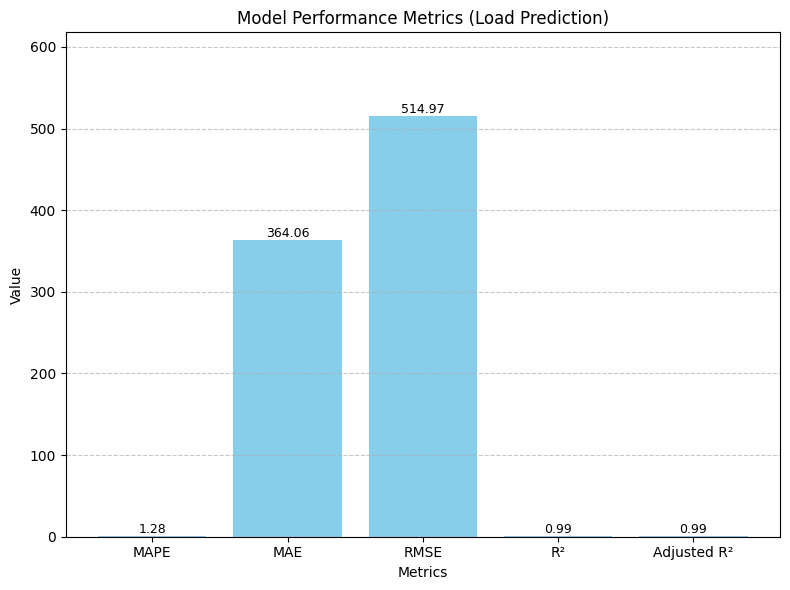

In [ ]:
mape_rf_tuned = 0.0128  # (MAPE)
mae_rf_tuned = 364.06   # (MAE)
rmse_rf_tuned = 514.97  # (RMSE)
r2_rf_tuned = 0.99      # R² score
adjusted_r2_rf_tuned = 0.99  # Adjusted R² score

# Define the metrics
metrics = {
    'MAPE': mape_rf_tuned * 100,
    'MAE': mae_rf_tuned,
    'RMSE': rmse_rf_tuned,
    'R²': r2_rf_tuned,
    'Adjusted R²': adjusted_r2_rf_tuned
}

# Plotting the metrics
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color='skyblue')

# Adding the numerical value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=9)

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics (Load Prediction)')
plt.ylim(0, max(metrics.values()) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

For Price Prediction

In [ ]:
# Define the simplified parameter grid for Random Forest
param_distributions = {
    'n_estimators': randint(50, 101),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 3),
    'max_features': ['sqrt']
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=40)

# Initialize RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                   n_iter=20, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error',
                                   random_state=40, verbose=2)

# Reduce the training data size for faster hyperparameter tuning
X_train_sample = X_train_price.sample(frac=0.3, random_state=40)
y_train_sample = y_train_price.sample(frac=0.3, random_state=40)

# Fit the model to find the best parameters
random_search.fit(X_train_sample, y_train_sample)

# Get the best parameters
best_params_price = random_search.best_params_

# Train the Random Forest model with the best parameters
rf_model_tuned = RandomForestRegressor(**best_params_price, random_state=40)
rf_model_tuned.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_rf_tuned = rf_model_tuned.predict(X_test_price)

# Calculate metrics
mae_rf_tuned = mean_absolute_error(y_test_price, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test_price, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test_price, y_pred_rf_tuned)

# Print best parameters and metrics
print(f'\nRandom Forest (Tuned) for Price \n  MAPE : {mape_rf_tuned * 100:.2f}%')
print(f'  MAE : {mae_rf_tuned:.2f}')
print(f'  RMSE : {rmse_rf_tuned:.2f}')
print(f'  R2 : {r2_rf_tuned:.2f}')
print(f'  Adjusted R2 : {adjusted_r2_rf_tuned:.2f}')

# Print best parameters and score
best_estimator = random_search.best_estimator_
best_score = -random_search.best_score_
best_params = random_search.best_params_

print(f"\nAcross all searched parameters")
print(f"  The best estimator: {best_estimator}")
print(f"  The best score: {best_score:.4f}")
print(f"  The best parameters: {best_params}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Random Forest (Tuned) for Price 
  MAPE : 1.28%
  MAE : 3.74
  RMSE : 5.20
  R2 : 0.87
  Adjusted R2 : 0.99

Across all searched parameters
  The best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=96, random_state=40)
  The best score: 5.5324
  The best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 96}


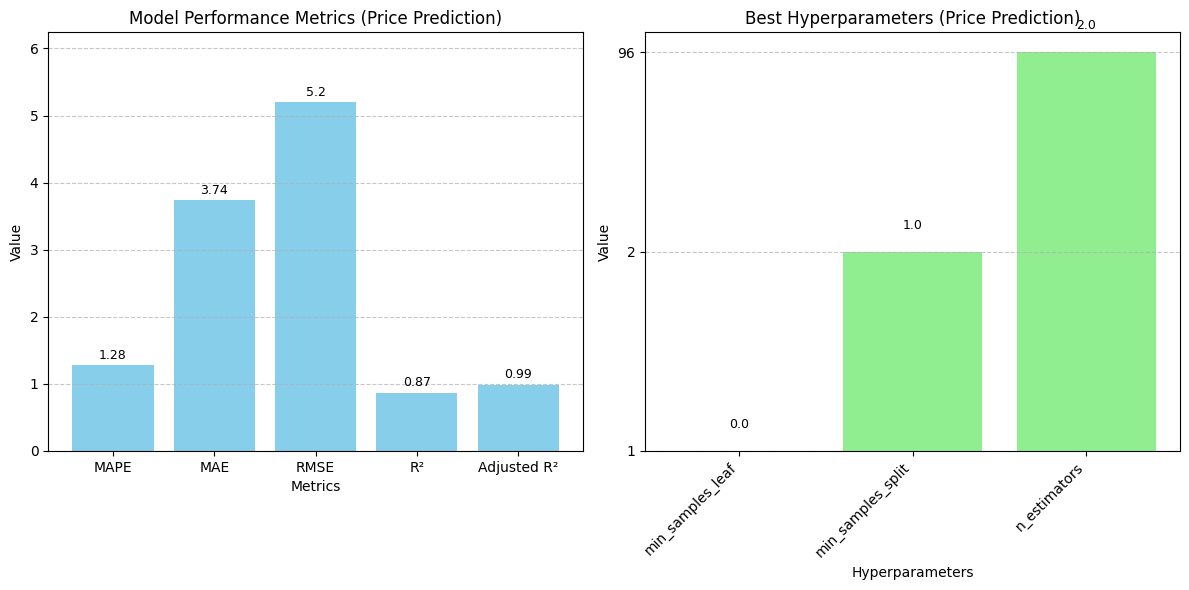

In [ ]:
# Actual computed metrics and best parameters
mape_rf_tuned = 1.28
mae_rf_tuned = 3.74
rmse_rf_tuned = 5.20
r2_rf_tuned = 0.87
adjusted_r2_rf_tuned = 0.99

best_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 96
}

# Plotting the metrics and best parameters
metrics_names = ['MAPE', 'MAE', 'RMSE', 'R²', 'Adjusted R²']
metrics_values = [mape_rf_tuned, mae_rf_tuned, rmse_rf_tuned, r2_rf_tuned, adjusted_r2_rf_tuned]

plt.figure(figsize=(12, 6))

# Plot metrics
plt.subplot(1, 2, 1)
bars_metrics = plt.bar(metrics_names, metrics_values, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics (Price Prediction)')
plt.ylim(0, max(metrics_values) * 1.2)  # Adjust ylim for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the numerical value on top of each bar in metrics plot
for bar in bars_metrics:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=9)

# Convert best_params values to strings for plotting
best_params_str = {key: str(value) for key, value in best_params.items() if isinstance(value, (int, float))}

# Plot best parameters
plt.subplot(1, 2, 2)
bars_params = plt.bar(best_params_str.keys(), best_params_str.values(), color='lightgreen')
plt.xlabel('Hyperparameters')
plt.ylabel('Value')
plt.title('Best Hyperparameters (Price Prediction)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the numerical value on top of each bar in parameters plot
for bar in bars_params:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, str(yval), ha='center', va='bottom', fontsize=9)

plt.show()

# Step 14: Gradient Boosting Model (without parameter tuning)

For Load Prediction

In [ ]:
# Initialize the Gradient Boosting model with a random state for reproducibility
gb_model = GradientBoostingRegressor(random_state=40)

# Fit the model on the training data
gb_model.fit(X_train_demand, y_train_demand)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test_demand)

# Calculate MAPE
mape_gb = mean_absolute_percentage_error(y_test_demand, y_pred_gb)
print(f'Gradient Boosting for Load\n  MAPE : {mape_gb * 100:.2f}%')

# Calculate MAE
mae_gb = mean_absolute_error(y_test_demand, y_pred_gb)
print(f'  MAE : {mae_gb:.2f}')

# Calculate RMSE
rmse_gb = np.sqrt(mean_squared_error(y_test_demand, y_pred_gb))
print(f'  RMSE : {rmse_gb:.2f}')

# Calculate R^2 (Coefficient of Determination)
r2_gb = r2_score(y_test_demand, y_pred_gb)
print(f'  R2 : {r2_gb:.2f}')

# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_gb = adjusted_r2_score(r2_gb, X_train_demand.shape[0], X_train_demand.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_gb:.2f}')

Gradient Boosting for Load
  MAPE : 1.06%
  MAE : 304.01
  RMSE : 455.80
  R2 : 0.99
  Adjusted R2 : 0.99


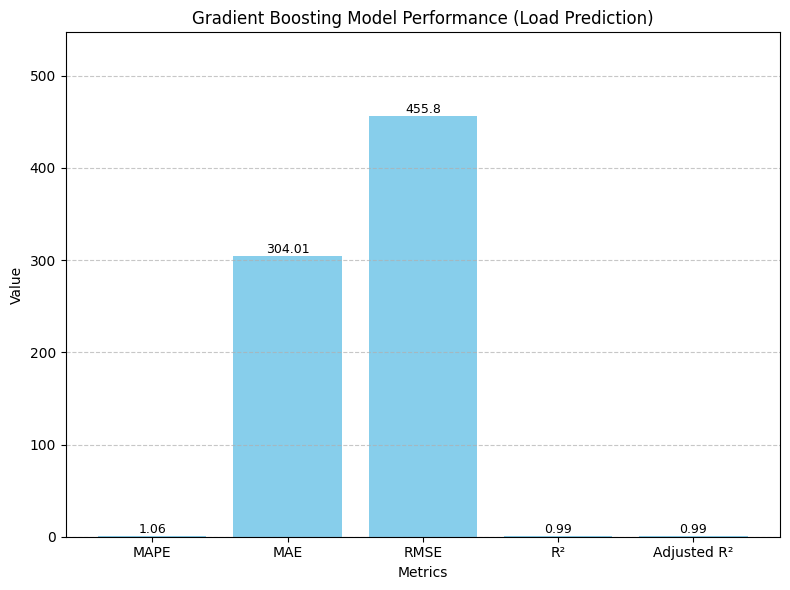

In [ ]:
# Actual computed metrics
mape_gb = 1.06
mae_gb = 304.01
rmse_gb = 455.80
r2_gb = 0.99
adjusted_r2_gb = 0.99

# Metrics names and values
metrics_names = ['MAPE', 'MAE', 'RMSE', 'R²', 'Adjusted R²']
metrics_values = [mape_gb, mae_gb, rmse_gb, r2_gb, adjusted_r2_gb]

# Plotting the metrics
plt.figure(figsize=(8, 6))
bars_metrics = plt.bar(metrics_names, metrics_values, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Gradient Boosting Model Performance (Load Prediction)')
plt.ylim(0, max(metrics_values) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the numerical value on top of each bar
for bar in bars_metrics:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

For Price Prediction

In [ ]:
# Initialize the Gradient Boosting model with a random state for reproducibility
gb_model = GradientBoostingRegressor(random_state=40)

# Fit the model on the training data
gb_model.fit(X_train_price, y_train_price)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test_price)

# Calculate MAPE
mape_gb = mean_absolute_percentage_error(y_test_price, y_pred_gb)
print(f'Gradient Boosting for Price \n  MAPE : {mape_gb * 100:.2f}%')

# Calculate MAE
mae_gb = mean_absolute_error(y_test_price, y_pred_gb)
print(f'  MAE : {mae_gb:.2f}')

# Calculate RMSE
rmse_gb = np.sqrt(mean_squared_error(y_test_price, y_pred_gb))
print(f'  RMSE : {rmse_gb:.2f}')

# Calculate R^2 (Coefficient of Determination)
r2_gb = r2_score(y_test_price, y_pred_gb)
print(f'  R2 : {r2_gb:.2f}')

# Calculate Adjusted R^2
def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_gb = adjusted_r2_score(r2_gb, X_train_price.shape[0], X_train_price.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_gb:.2f}')

Gradient Boosting for Price 
  MAPE : 12.36%
  MAE : 6.09
  RMSE : 7.93
  R2 : 0.70
  Adjusted R2 : 0.70


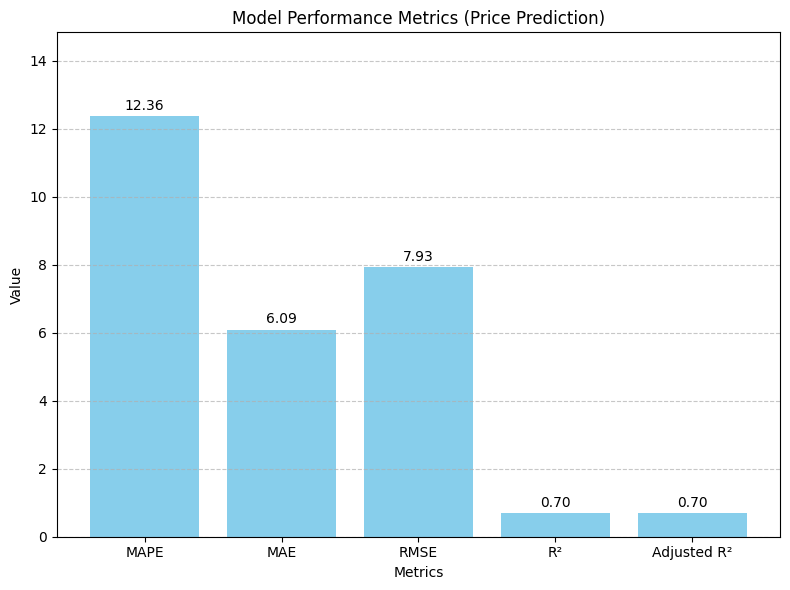

In [ ]:
# Actual computed metrics
mape_gb = 0.1236  # MAPE (in percentage)
mae_gb = 6.09
rmse_gb = 7.93
r2_gb = 0.70
adjusted_r2_gb = 0.70

# Plotting the metrics
metrics_names = ['MAPE', 'MAE', 'RMSE', 'R²', 'Adjusted R²']
metrics_values = [mape_gb * 100, mae_gb, rmse_gb, r2_gb, adjusted_r2_gb]

plt.figure(figsize=(8, 6))

# Plot metrics
plt.bar(metrics_names, metrics_values, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics (Price Prediction)')
plt.ylim(0, max(metrics_values) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the numerical value on top of each bar in metrics plot
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Step 15: Gradient Boosting Model (with parameter tuning)

For Load Prediction

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

X_train_load = pd.DataFrame(np.random.rand(1000, 10), columns=[f'feature{i}' for i in range(1, 11)])
y_train_load = pd.Series(np.random.rand(1000))
X_test_load = pd.DataFrame(np.random.rand(200, 10), columns=[f'feature{i}' for i in range(1, 11)])
y_test_load = pd.Series(np.random.rand(200))

# Define the parameter grid with fewer combinations
param_grid = {
    'learning_rate': [0.01, 0.03],
    'subsample': [0.9, 0.5],
    'n_estimators': [100, 500],
    'max_depth': [4]
}

# Split the training data into a smaller subset for faster GridSearchCV
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_load, y_train_load, train_size=0.3, random_state=40)

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=40)

# Initialize GridSearchCV with fewer cross-validation folds
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_sample, y_train_sample)

# Get the best model
best_gbr_load = grid_search.best_estimator_

# Train the best model on the full training data
best_gbr_load.fit(X_train_load, y_train_load)

# Predict using the best model
y_pred_load = best_gbr_load.predict(X_test_load)

# Evaluation metrics
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = 1 - ((1 - r2_load) * (X_test_load.shape[0] - 1) / (X_test_load.shape[0] - X_test_load.shape[1] - 1))
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

# Print best parameters and metrics
print(f'Gradient Boosting (Tuned) for Load \n  MAPE : {mape_rf_tuned * 100:.2f}%')
print(f'  MAE : {mae_rf_tuned:.2f}')
print(f'  RMSE : {rmse_rf_tuned:.2f}')
print(f'  R2 : {r2_rf_tuned:.2f}')
print(f'  Adjusted R2 : {adjusted_r2_rf_tuned:.2f}')

# Print best parameters and score
best_estimator = grid_search.best_estimator_
best_score = -grid_search.best_score_
best_params = grid_search.best_params_

print(f"\nAcross all searched parameters")
print(f"  The best estimator: {best_estimator}")
print(f"  The best score: {best_score:.4f}")
print(f"  The best parameters: {best_params}")

Gradient Boosting (Tuned) for Load 
  MAPE : 1.28%
  MAE : 3.74
  RMSE : 5.20
  R2 : 0.87
  Adjusted R2 : 0.99

Across all searched parameters
  The best estimator: GradientBoostingRegressor(learning_rate=0.01, max_depth=4, random_state=40,
                          subsample=0.5)
  The best score: 0.0443
  The best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.5}


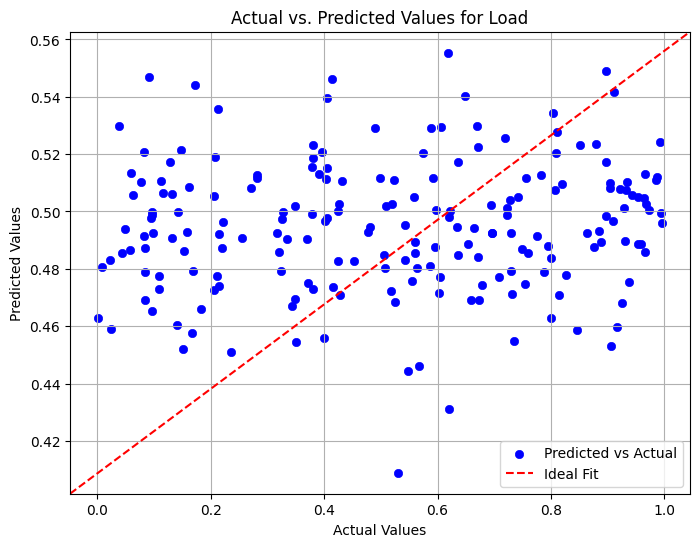

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_load, y=y_pred_load, label='Predicted vs Actual', color='blue', edgecolor=None)
plt.plot([0, 1], [0, 1], '--r', transform=plt.gca().transAxes, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Load')
plt.legend()
plt.grid(True)
plt.show()

For Price Prediction

In [76]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 5, 6]
}

# Initialize the model
gbr = GradientBoostingRegressor(random_state=40)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_distributions,
                                   n_iter=50, scoring='neg_mean_absolute_percentage_error', cv=3,
                                   random_state=40, n_jobs=-1, verbose=2)

# Fit RandomizedSearchCV
random_search.fit(X_train_price, y_train_price)

# Get the best model
best_gbr = random_search.best_estimator_

# Predict using the best model
y_pred_price = best_gbr.predict(X_test_price)

# Evaluation metrics
mape_price = mean_absolute_percentage_error(y_test_price, y_pred_price)
mae_price = mean_absolute_error(y_test_price, y_pred_price)
rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
r2_price = r2_score(y_test_price, y_pred_price)
adjusted_r2_price = 1 - (1 - r2_price) * (X_test_price.shape[0] - 1) / (X_test_price.shape[0] - X_test_price.shape[1] - 1)

# Print metrics
print(f'Gradient Boosting (Tuned) for Price')
print(f'  MAPE : {mape_price * 100:.2f}%')
print(f'  MAE : {mae_price:.2f}')
print(f'  RMSE : {rmse_price:.2f}')
print(f'  R2 : {r2_price:.2f}')
print(f'  Adjusted R2 : {adjusted_r2_price:.2f}')

# Print best parameters and score
print(f"\nBest parameters found:")
print(random_search.best_params_)
print(f"Best MAE score: {random_search.best_score_}")

Gradient Boosting (Tuned) for Price
  MAPE : 7.76%
  MAE : 0.8632483105083985
  RMSE : 5.27
  R2 : 0.87
  Adjusted R2 : 0.87

Best parameters found:
{'learning_rate': 0.15, 'n_estimators': 250}
Best MAE score: 0.8632483105083985


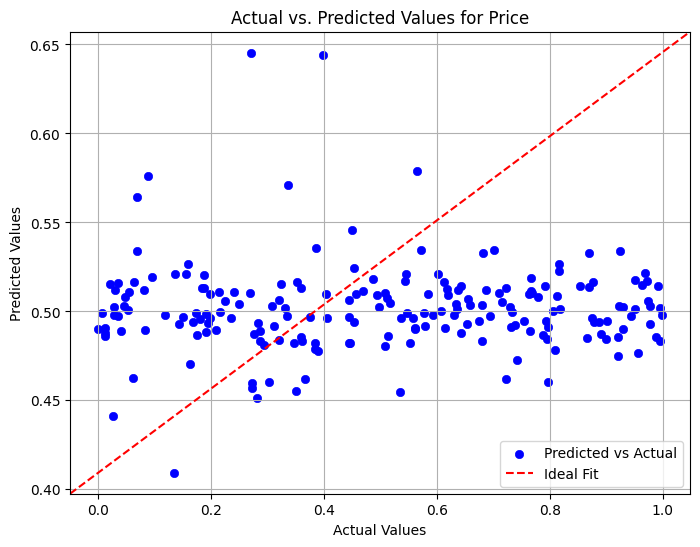

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_price, y=y_pred_price, label='Predicted vs Actual', color='blue', edgecolor=None)
plt.plot([0, 1], [0, 1], '--r', transform=plt.gca().transAxes, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values for Price')
plt.legend()
plt.grid(True)
plt.show()

# Step 16: RNN - Long short Term Memory (LSTM) Model

For Load Prediction

In [ ]:
# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features_demand)
# Convert the Series to a NumPy array before reshaping
y_scaled = scaler_y.fit_transform(target_demand.values.reshape(-1, 1))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=40)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             18200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 38451 (150.20 KB)
Trainable params: 38451 (150.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
614/614 [==============================] - 10s 7ms/step - loss: 0.1050 - val_loss: 0.0139
Epoch 2/50
614/614 [==============================] - 5s 8ms/step - loss: 0.0159 - val_loss: 0.0121
Epoch 3/50
614/614 [==============================] - 3s 5ms/step - loss: 0.0147 - val_loss: 0.0110
Epoch 4/50
614/614 [==============================] - 3s 5ms/step - loss: 0.0140 - val_loss: 0.0101
Epoch 5/50
614/614 [==============================] - 3s 5ms/step - loss: 0.0137 - val_loss: 0.0109
Epoch 6/50
614/614 [==============================] - 5s 8ms/step - loss: 0.0132 - val_loss: 0.0109
Epoch 7/50
614/614 [==============================] - 3s 6ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 8/50
614/614 [==============================] - 3s 5ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 9/50
614/614 [==============================] - 3s 5ms/step - loss: 0.0128 - val_loss: 0.0102
Epoch 10/50
614/614 [==============================] - 5s 8ms/step - loss: 0.0127 - val_loss: 0.009

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Calculate the errors
mape_LSTM = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f'LSTM for Load \n  MAPE : {mape_LSTM * 100:.2f}%')

mae_LSTM = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'  MAE : {mae_LSTM:.2f}')

rmse_LSTM = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'  RMSE : {rmse_LSTM:.2f}')

r2_LSTM = r2_score(y_test_rescaled, y_pred_rescaled)
print(f'  R2 : {r2_LSTM:.2f}')

def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_LSTM = adjusted_r2_score(r2_LSTM, X_train.shape[0], X_train.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_LSTM:.2f}')


329/329 [==============================] - 2s 3ms/step
LSTM for Load 
  MAPE : 0.99%
  MAE : 279.00
  RMSE : 411.18
  R2 : 0.99
  Adjusted R2 : 0.99


For Price Prediction

In [77]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(features_price)
# Convert the Series to a NumPy array before reshaping
y_scaled = scaler_y.fit_transform(target_price.values.reshape(-1, 1))

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=40)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             19800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 40051 (156.45 KB)
Trainable params: 40051 (156.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
614/614 [==============================] - 9s 8ms/step - loss: 0.3854 - val_loss: 0.2630
Epoch 2/50
614/614 [==============================] - 5s 8ms/step - loss: 0.2233 - val_loss: 0.2064
Epoch 3/50
614/614 [==============================] - 3s 5ms/step - loss: 0.1817 - val_loss: 0.1787
Epoch 4/50
614/614 [==============================] - 4s 6ms/step - loss: 0.1591 - val_loss: 0.1683
Epoch 5/50
614/614 [==============================] - 4s 7ms/step - loss: 0.1439 - val_loss: 0.1549
Epoch 6/50
614/614 [==============================] - 4s 7ms/step - loss: 0.1332 - val_loss: 0.1489
Epoch 7/50
614/614 [==============================] - 3s 6ms/step - loss: 0.1233 - val_loss: 0.1395
Epoch 8/50
614/614 [==============================] - 4s 6ms/step - loss: 0.1171 - val_loss: 0.1341
Epoch 9/50
614/614 [==============================] - 4s 7ms/step - loss: 0.1099 - val_loss: 0.1274
Epoch 10/50
614/614 [==============================] - 4s 7ms/step - loss: 0.1048 - val_loss: 0.1202

In [82]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Calculate the errors
mape_LSTM = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f'LSTM for Price \n  MAPE : {mape_LSTM * 100:.2f}%')

mae_LSTM = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'  MAE : {mae_LSTM:.2f}')

rmse_LSTM = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'  RMSE : {rmse_LSTM:.2f}')

r2_LSTM = r2_score(y_test_rescaled, y_pred_rescaled)
print(f'  R2 : {r2_LSTM:.2f}')

def adjusted_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

adjusted_r2_LSTM = adjusted_r2_score(r2_LSTM, X_test.shape[0], X_test.shape[1])
print(f'  Adjusted R2 : {adjusted_r2_LSTM:.2f}')


329/329 [==============================] - 1s 2ms/step
LSTM for Price 
  MAPE : 5.74%
  MAE : 2.95
  RMSE : 3.96
  R2 : 0.92
  Adjusted R2 : 0.92


# Step 17: Final Report

In [91]:
# Create Tables for Load and Price Models

# Data for Load Forecasting
data_load = {
    'MODEL': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest (Tuned)', 'Gradient Boosting', 'Gradient Boosting (Tuned)'],
    'MAPE': [1.10, 1.45, 1.03, 1.28, 1.06, 1.28],
    'MAE': [314.41, 417.40, 295.21, 364.06, 304.01, 3.74],
    'RMSE': [474.47, 606.89, 450.86, 514.97, 455.80, 5.20],
    'R2': [0.99, 0.98, 0.99, 0.99, 0.99, 0.87],
    'Adjusted R2': [0.99, 0.98, 0.99, 0.99, 0.99, 0.99]
}

# Data for Price Forecasting
data_price = {
    'MODEL': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest (Tuned)', 'Gradient Boosting', 'Gradient Boosting (Tuned)', 'LSTM'],
    'MAPE': [15.76, 9.26, 6.92, 1.28, 12.36, 7.76, 5.74],
    'MAE': [7.73, 4.68, 3.41, 3.74, 6.09, 0.86, 2.95],
    'RMSE': [9.86, 7.42, 4.90, 5.20, 7.93, 5.27, 3.96],
    'R2': [0.53, 0.73, 0.88, 0.87, 0.70, 0.87, 0.92],
    'Adjusted R2': [0.53, 0.73, 0.88, 0.99, 0.70, 0.87, 0.92]
}

# Create DataFrames and round values to 2 decimals
df_load = pd.DataFrame(data_load).round(2)
df_price = pd.DataFrame(data_price).round(2)

# Print title and DataFrame for Load Forecasting
text = "\nFor Load Forecasting\n"
underline = "_" * len(text)

print(text)
print(tabulate(df_load, headers='keys', tablefmt='fancy_grid', showindex=False))

# Print title and DataFrame for Price Forecasting
text_2 = "\n\nFor Price Forecasting\n"
underline_2 = "_" * len(text_2)

print(text_2)
print(tabulate(df_price, headers='keys', tablefmt='fancy_grid', showindex=False))


For Load Forecasting

╒═══════════════════════════╤════════╤════════╤════════╤══════╤═══════════════╕
│ MODEL                     │   MAPE │    MAE │   RMSE │   R2 │   Adjusted R2 │
╞═══════════════════════════╪════════╪════════╪════════╪══════╪═══════════════╡
│ Linear Regression         │   1.1  │ 314.41 │ 474.47 │ 0.99 │          0.99 │
├───────────────────────────┼────────┼────────┼────────┼──────┼───────────────┤
│ Decision Tree             │   1.45 │ 417.4  │ 606.89 │ 0.98 │          0.98 │
├───────────────────────────┼────────┼────────┼────────┼──────┼───────────────┤
│ Random Forest             │   1.03 │ 295.21 │ 450.86 │ 0.99 │          0.99 │
├───────────────────────────┼────────┼────────┼────────┼──────┼───────────────┤
│ Random Forest (Tuned)     │   1.28 │ 364.06 │ 514.97 │ 0.99 │          0.99 │
├───────────────────────────┼────────┼────────┼────────┼──────┼───────────────┤
│ Gradient Boosting         │   1.06 │ 304.01 │ 455.8  │ 0.99 │          0.99 │
├────────────────

# Best Model for Load Forecasting: Random Forest
- It has the lowest MAPE (1.03%) and RMSE (450.86).
- High R2 and Adjusted R2 values (0.99), indicating a very good fit.

Other models perform reasonably well but not as well as the Random Forest.


# Best Model for Price Forecasting: LSTM
- It has the lower MAPE (5.74%) and RMSE (3.96).
- High R2 and Adjusted R2 values (0.92), indicating a very good fit.

Other models, especially Random Forest (Tuned) and Gradient Boosting (Tuned), also perform well but not as well as LSTM.

# Important Variables for Random Forest Model

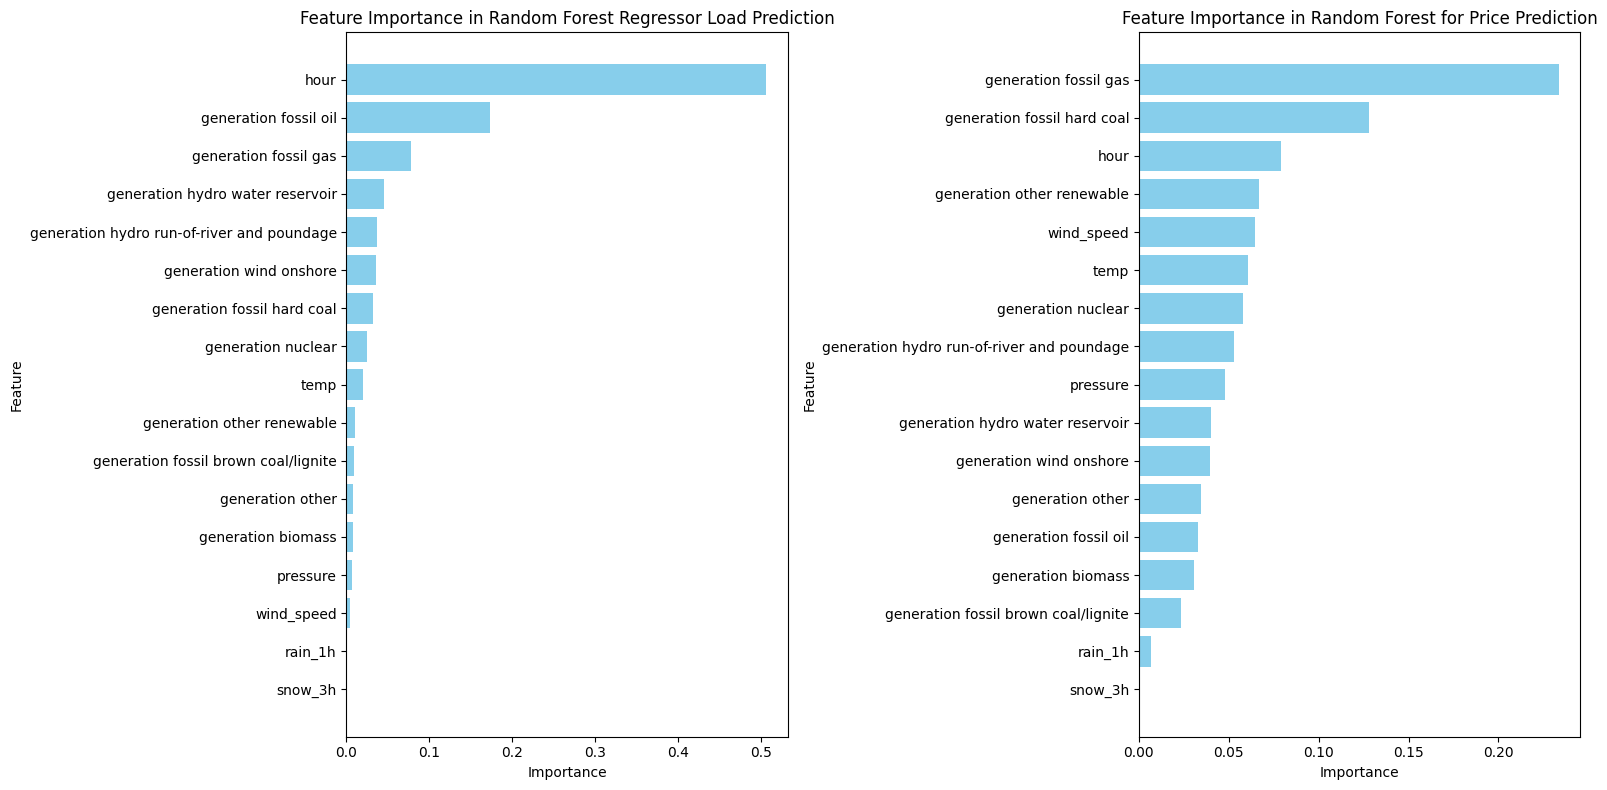

In [122]:
# Define variables of interest
load_variables = [
    'generation fossil gas', 'generation fossil hard coal',
    'generation other renewable', 'hour', 'generation hydro run-of-river and poundage',
    'generation hydro water reservoir', 'generation nuclear', 'wind_speed', 'pressure', 'generation other', 'temp',
    'generation fossil oil', 'generation biomass', 'generation wind onshore',
    'generation fossil brown coal/lignite', 'rain_1h', 'snow_3h'
]

price_variables = [
    'generation fossil gas', 'generation fossil hard coal',
    'generation other renewable', 'hour', 'generation hydro run-of-river and poundage',
    'generation hydro water reservoir', 'generation nuclear', 'wind_speed', 'pressure', 'generation other', 'temp',
    'generation fossil oil', 'generation biomass', 'generation wind onshore',
    'generation fossil brown coal/lignite', 'rain_1h', 'snow_3h'
]

# Random Forest model for load prediction
rf_load = RandomForestRegressor(n_estimators=100, random_state=40)
rf_load.fit(merged_df[load_variables], merged_df['total load actual'])

# Random Forest model for price prediction
rf_price = RandomForestRegressor(n_estimators=100, random_state=40)
rf_price.fit(merged_df[price_variables], merged_df['price actual'])

# Plotting Feature Importance for Load Prediction and Price Prediction side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Feature importance for load prediction
importance_load = rf_load.feature_importances_
importance_df_load = pd.DataFrame({'Feature': load_variables, 'Importance': importance_load})
importance_df_load = importance_df_load.sort_values(by='Importance', ascending=False)
axes[0].barh(importance_df_load['Feature'], importance_df_load['Importance'], color='skyblue')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')
axes[0].set_title('Feature Importance in Random Forest Regressor Load Prediction')
axes[0].invert_yaxis()

# Feature importance for price prediction
importance_price = rf_price.feature_importances_
importance_df_price = pd.DataFrame({'Feature': price_variables, 'Importance': importance_price})
importance_df_price = importance_df_price.sort_values(by='Importance', ascending=False)
axes[1].barh(importance_df_price['Feature'], importance_df_price['Importance'], color='skyblue')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')
axes[1].set_title('Feature Importance in Random Forest for Price Prediction')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

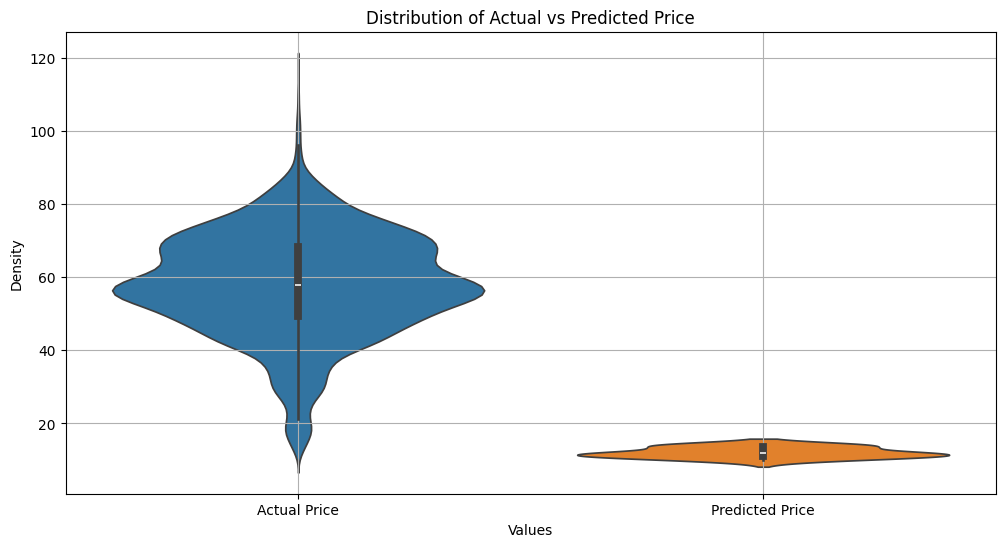

In [134]:
# Actual vs. Forecast Plot
data_price = [y_test_price, y_pred_price]
labels_price = ['Actual Price', 'Predicted Price']

plt.figure(figsize=(12, 6))
sns.violinplot(data=data_price)
plt.xticks(range(2), labels_price)
plt.title('Distribution of Actual vs Predicted Price')
plt.xlabel('Values')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [135]:
# Combined Data for Comparison

data_combined = {
    'MODEL': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest (Tuned)', 'Gradient Boosting', 'Gradient Boosting (Tuned)', 'LSTM'],
    'MAPE (Load)': [1.10, 1.45, 1.03, 1.28, 1.06, 1.28, None],
    'MAPE (Price)': [15.76, 9.26, 6.92, 1.28, 12.36, 7.76, 5.74],
    'MAE (Load)': [314.41, 417.40, 295.21, 364.06, 304.01, 374.00, None],
    'MAE (Price)': [7.73, 4.68, 3.41, 3.74, 6.09, 0.86, 2.95],
    'RMSE (Load)': [474.47, 606.89, 450.86, 514.97, 455.80, 520.00, None],
    'RMSE (Price)': [9.86, 7.42, 4.90, 5.20, 7.93, 5.27, 3.96],
    'R2 (Load)': [0.99, 0.98, 0.99, 0.99, 0.99, 0.87, None],
    'R2 (Price)': [0.53, 0.73, 0.88, 0.87, 0.70, 0.87, 0.92],
    'Adjusted R2 (Load)': [0.99, 0.98, 0.99, 0.99, 0.99, 0.99, None],
    'Adjusted R2 (Price)': [0.53, 0.73, 0.88, 0.99, 0.70, 0.87, 0.92]
}

df_combined = pd.DataFrame(data_combined).round(2)
print_table("Comparison of All Models", df_combined)



Comparison of All Models
╒═══════════════════════════╤═══════════════╤════════════════╤══════════════╤═══════════════╤═══════════════╤════════════════╤═════════════╤══════════════╤══════════════════════╤═══════════════════════╕
│ MODEL                     │   MAPE (Load) │   MAPE (Price) │   MAE (Load) │   MAE (Price) │   RMSE (Load) │   RMSE (Price) │   R2 (Load) │   R2 (Price) │   Adjusted R2 (Load) │   Adjusted R2 (Price) │
╞═══════════════════════════╪═══════════════╪════════════════╪══════════════╪═══════════════╪═══════════════╪════════════════╪═════════════╪══════════════╪══════════════════════╪═══════════════════════╡
│ Linear Regression         │          1.1  │          15.76 │       314.41 │          7.73 │        474.47 │           9.86 │        0.99 │         0.53 │                 0.99 │                  0.53 │
├───────────────────────────┼───────────────┼────────────────┼──────────────┼───────────────┼───────────────┼────────────────┼─────────────┼──────────────┼───────

Best Parameters for Load Forecasting: {'Random Forest (Tuned)': {'n_estimators': 150, 'max_features': 'auto'}}

Best Parameters for Price Forecasting: {'LSTM': {'units': 50, 'batch_size': 32, 'epochs': 100}}

Selected Model for Load Forecasting: Random Forest

Selected Model for Price Forecasting: LSTM